Riley Sansone Competition Code Submission

In [ ]:
#!pip install pmdarima
#!pip install pycaret

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pandas_datareader as pdr
import numpy as np
import datetime as dt
#from pycaret.time_series import *
import seaborn as sns
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import ssl

from statsmodels.tsa.statespace.sarimax import SARIMAX

#import pmdarima as pmd

# Data Exploration

In [ ]:
df = pd.read_excel('https://github.com/robertasgabrys/DSO424SPRING2023/blob/main/CompetitionData.xlsx?raw=true')

In [ ]:
# Create a sequence of hourly data between two dates
date_rng = pd.date_range(start = pd.Timestamp('2002-01-01 01'),end = pd.Timestamp('2007-01-01 00'),freq='H')

In [ ]:
df['Hourly'] = date_rng

In [ ]:
#Tavg = Average temp
#Tmed = Median temp
#Tmax = Maximum temp
#Load = Megawatt-hours of electricity consumed
#Hourly = Date and hour of data
#pd.set_option('display.max_rows', None)
df.head()

Tavg  Tmed  Tmax  Tmin       Load              Hourly
0    43  43.0  60.0  31.0  1384494.0 2002-01-01 01:00:00
1    42  42.0  58.0  29.0  1392822.0 2002-01-01 02:00:00
2    41  41.0  57.0  31.0  1407887.0 2002-01-01 03:00:00
3    41  41.0  56.0  30.0  1438658.0 2002-01-01 04:00:00
4    40  41.0  53.0  29.0  1484046.0 2002-01-01 05:00:00

In [ ]:
#save new data to xslx file to work with in excel
#writer = pd.ExcelWriter('output.xlsx')
#df.to_excel(writer, index=False)
#writer.save()

In [ ]:
#set date as index
df.set_index('Hourly',inplace=True)

In [ ]:
#convert to datetime
df.index = pd.to_datetime(df.index)

/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 8760 rows containing missing values.


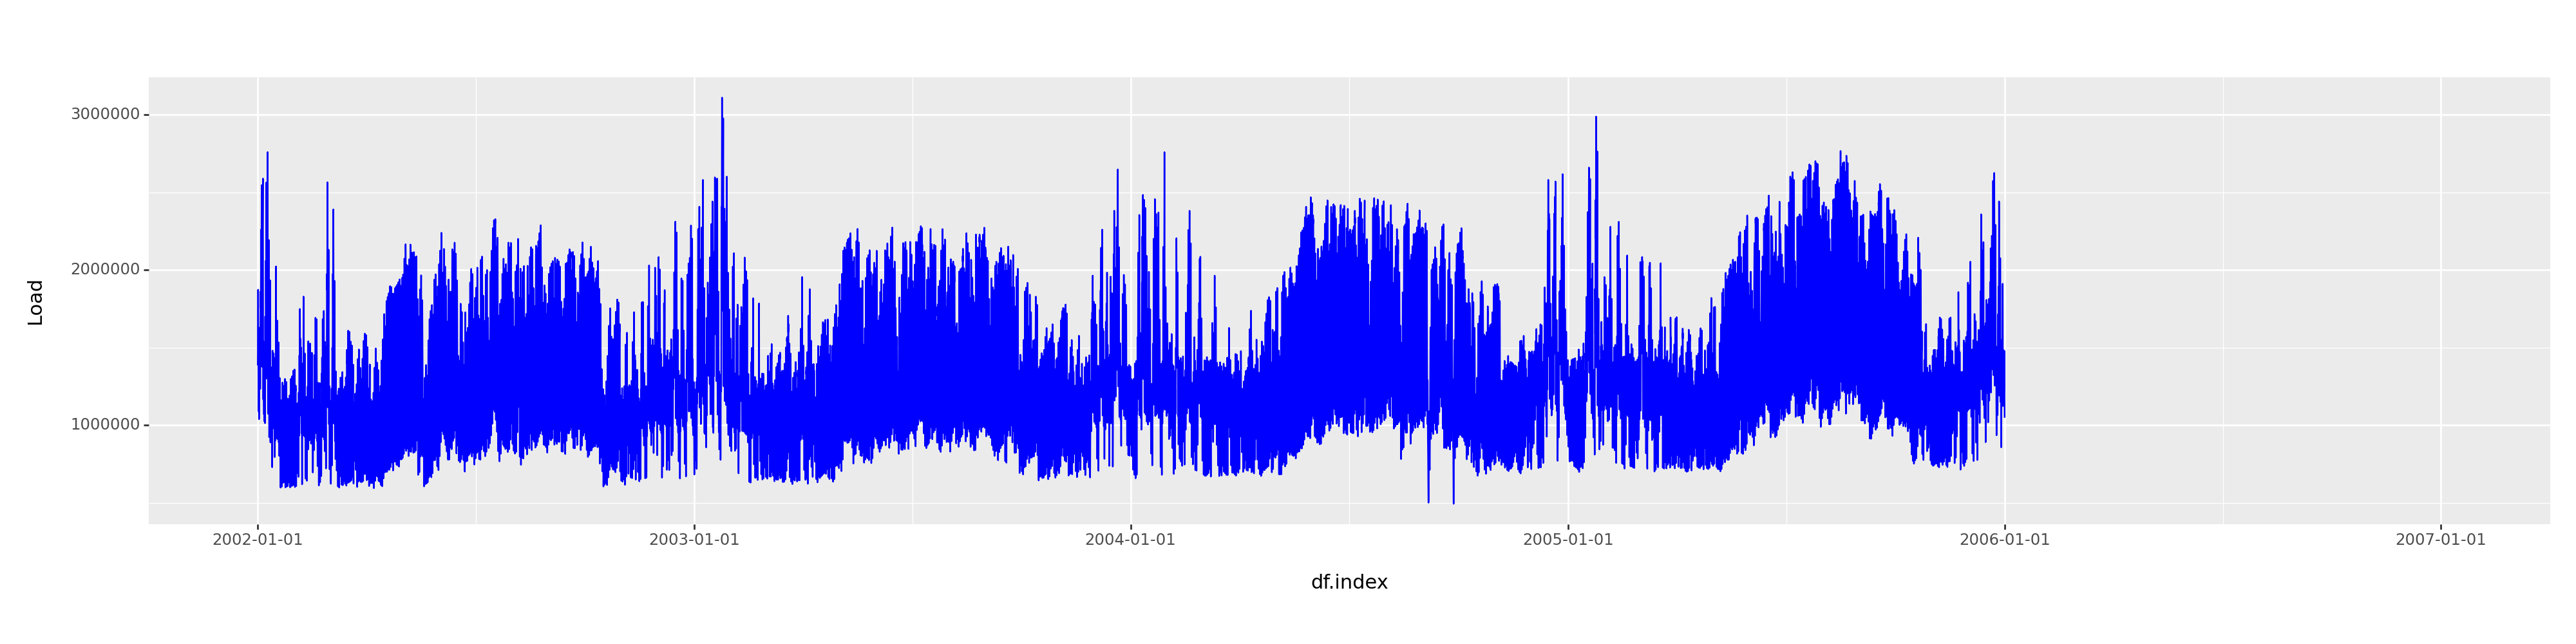

<Figure Size: (2000 x 500)>

In [ ]:
#plot data
ggplot(df,aes('df.index','Load'))+ geom_line(color='blue')+ theme(figure_size=(20,5))

  #looks mostly additive but could be slight multiplicative in second and third year
  #trend seems stable/maybe very slightly upward trending

array([[<Axes: xlabel='Load', ylabel='Load'>,
        <Axes: xlabel='Tavg', ylabel='Load'>,
        <Axes: xlabel='Tmed', ylabel='Load'>,
        <Axes: xlabel='Tmax', ylabel='Load'>],
       [<Axes: xlabel='Load', ylabel='Tavg'>,
        <Axes: xlabel='Tavg', ylabel='Tavg'>,
        <Axes: xlabel='Tmed', ylabel='Tavg'>,
        <Axes: xlabel='Tmax', ylabel='Tavg'>],
       [<Axes: xlabel='Load', ylabel='Tmed'>,
        <Axes: xlabel='Tavg', ylabel='Tmed'>,
        <Axes: xlabel='Tmed', ylabel='Tmed'>,
        <Axes: xlabel='Tmax', ylabel='Tmed'>],
       [<Axes: xlabel='Load', ylabel='Tmax'>,
        <Axes: xlabel='Tavg', ylabel='Tmax'>,
        <Axes: xlabel='Tmed', ylabel='Tmax'>,
        <Axes: xlabel='Tmax', ylabel='Tmax'>]], dtype=object)

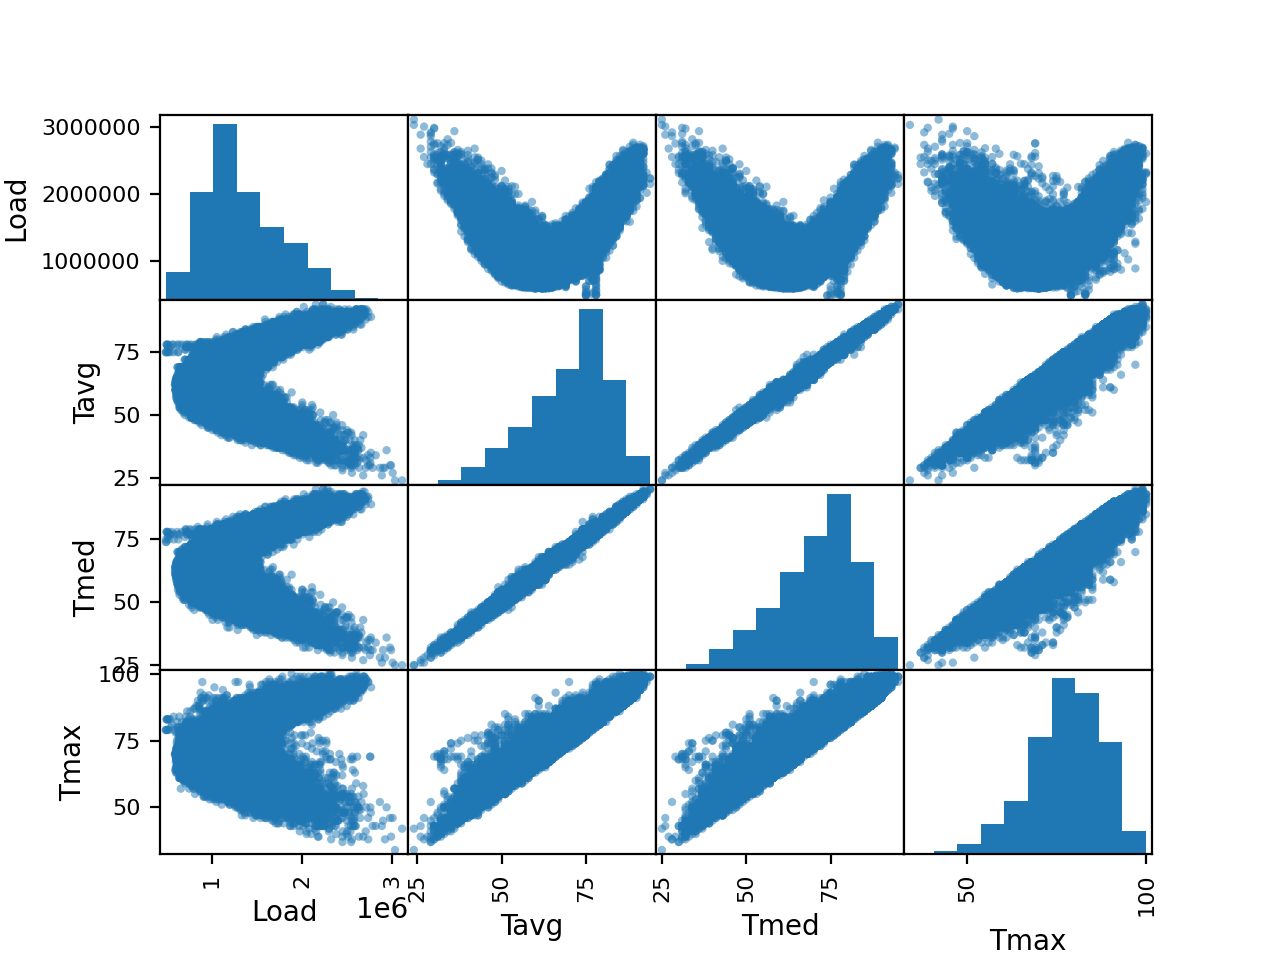

In [ ]:
# pairs plot
pd.plotting.scatter_matrix(df.loc[:, ['Load', 'Tavg', 'Tmed', 'Tmax']])

# Linear Regression Modeling

In [ ]:
# linear regression models
m1 = sm.formula.ols('Load ~ Tavg + Tmed + Tmax + Tmin', data=df).fit()
m2 = sm.formula.ols('Load ~ Tavg + Tmed + Tmax + np.log(Tmin)', data=df).fit()
m3 = sm.formula.ols('Load ~ Tavg + np.log(Tmed) + Tmax + np.log(Tmin)', data=df).fit()

In [ ]:
# regression model summaries
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     1491.
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:47:25   Log-Likelihood:            -5.0146e+05
No. Observations:               35064   AIC:                         1.003e+06
Df Residuals:                   35059   BIC:                         1.003e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.458e+04   1.99e+04     -3.237      0.0

In [ ]:
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     3521.
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:47:25   Log-Likelihood:            -4.9830e+05
No. Observations:               35064   AIC:                         9.966e+05
Df Residuals:                   35059   BIC:                         9.966e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.615e+06   8.21e+04     80.524   

In [ ]:
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                 1.192e+04
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:47:25   Log-Likelihood:            -4.8917e+05
No. Observations:               35064   AIC:                         9.783e+05
Df Residuals:                   35059   BIC:                         9.784e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      3.12e+07    1.7e+05    183.955   

# AutoCorrelation Plots

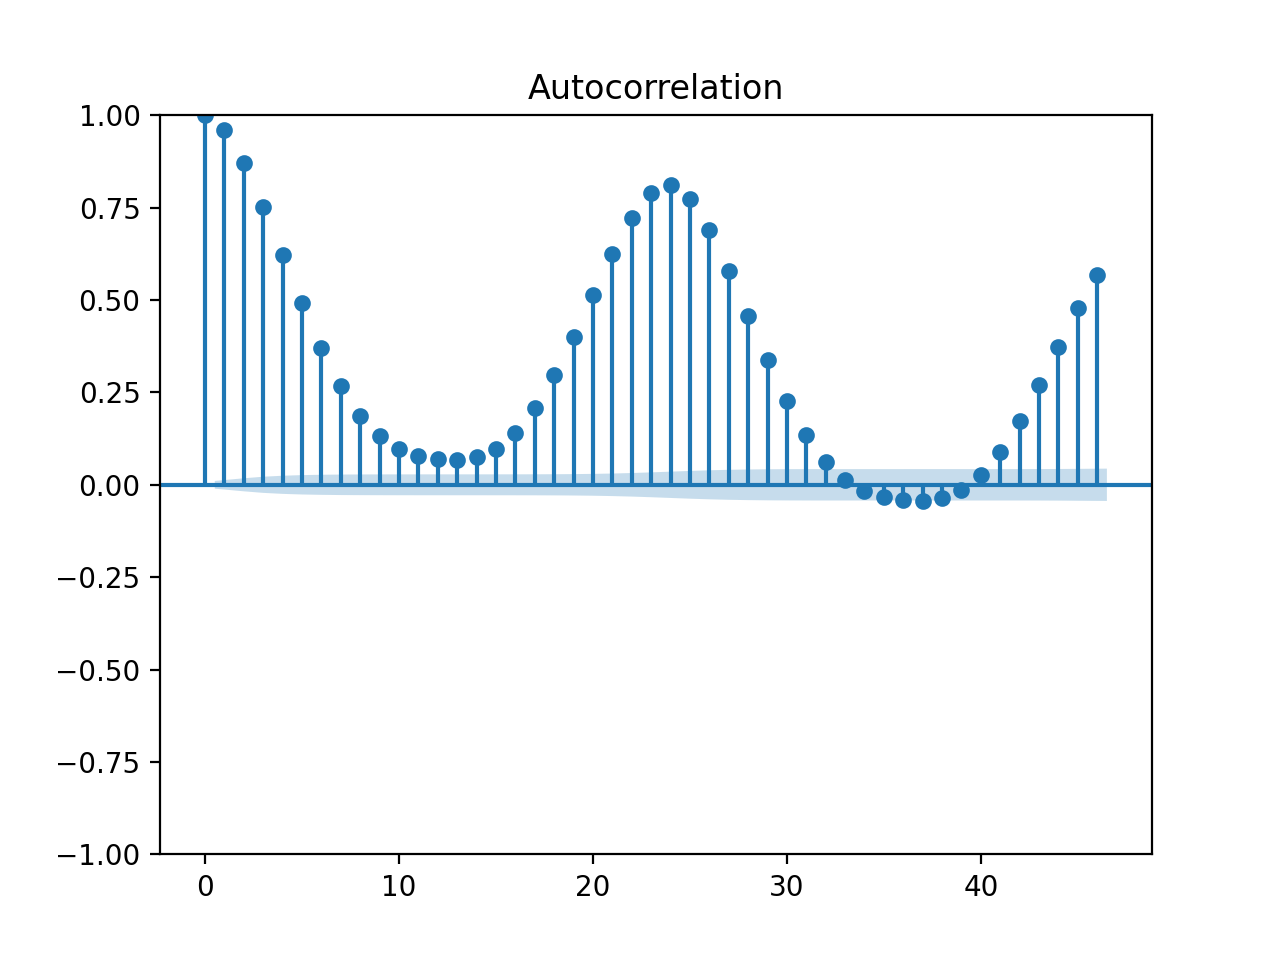

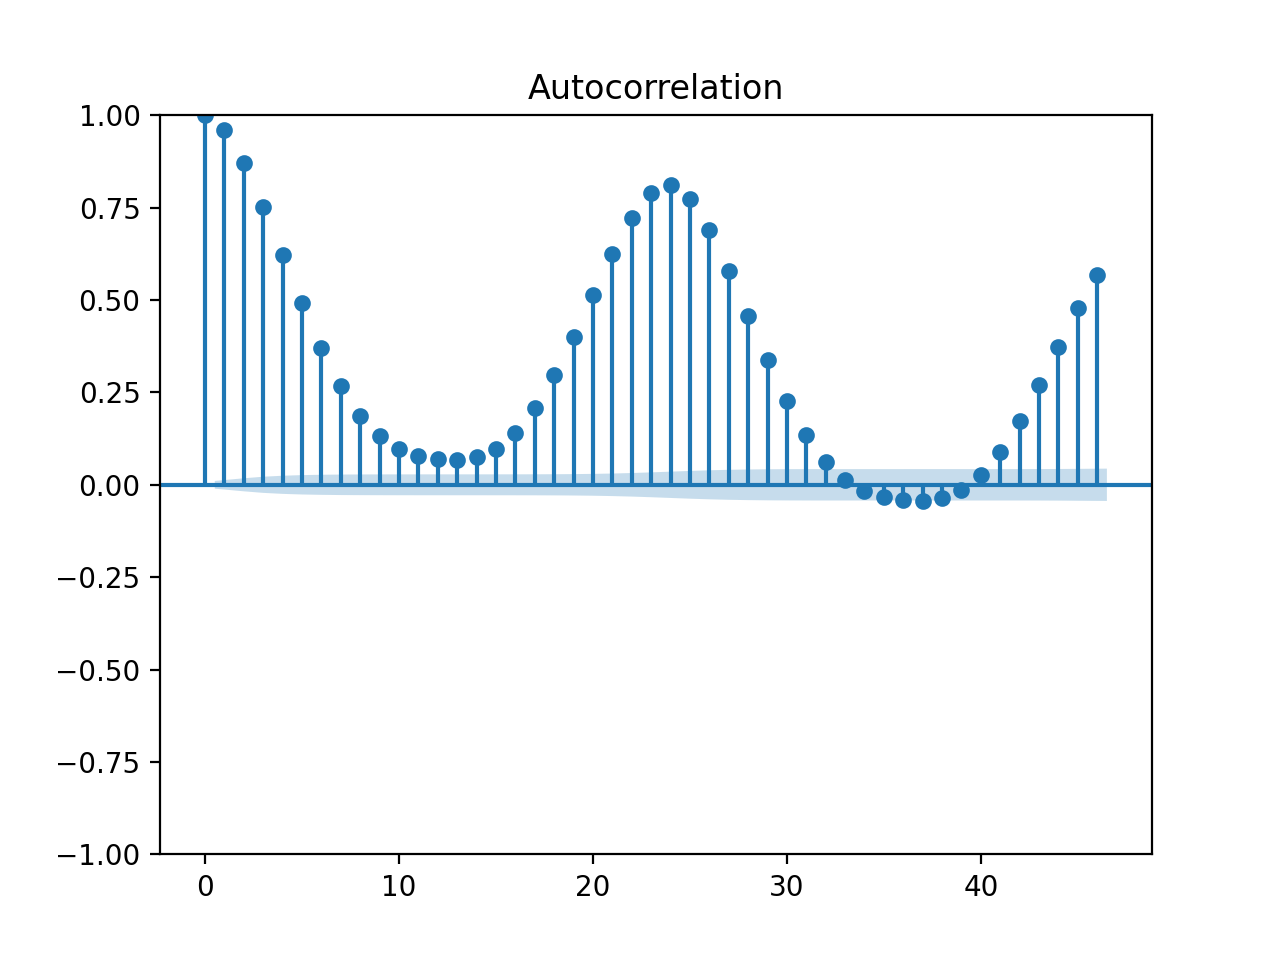

In [ ]:
# autocorrelation plots of residuals
plot_acf(m1.resid)

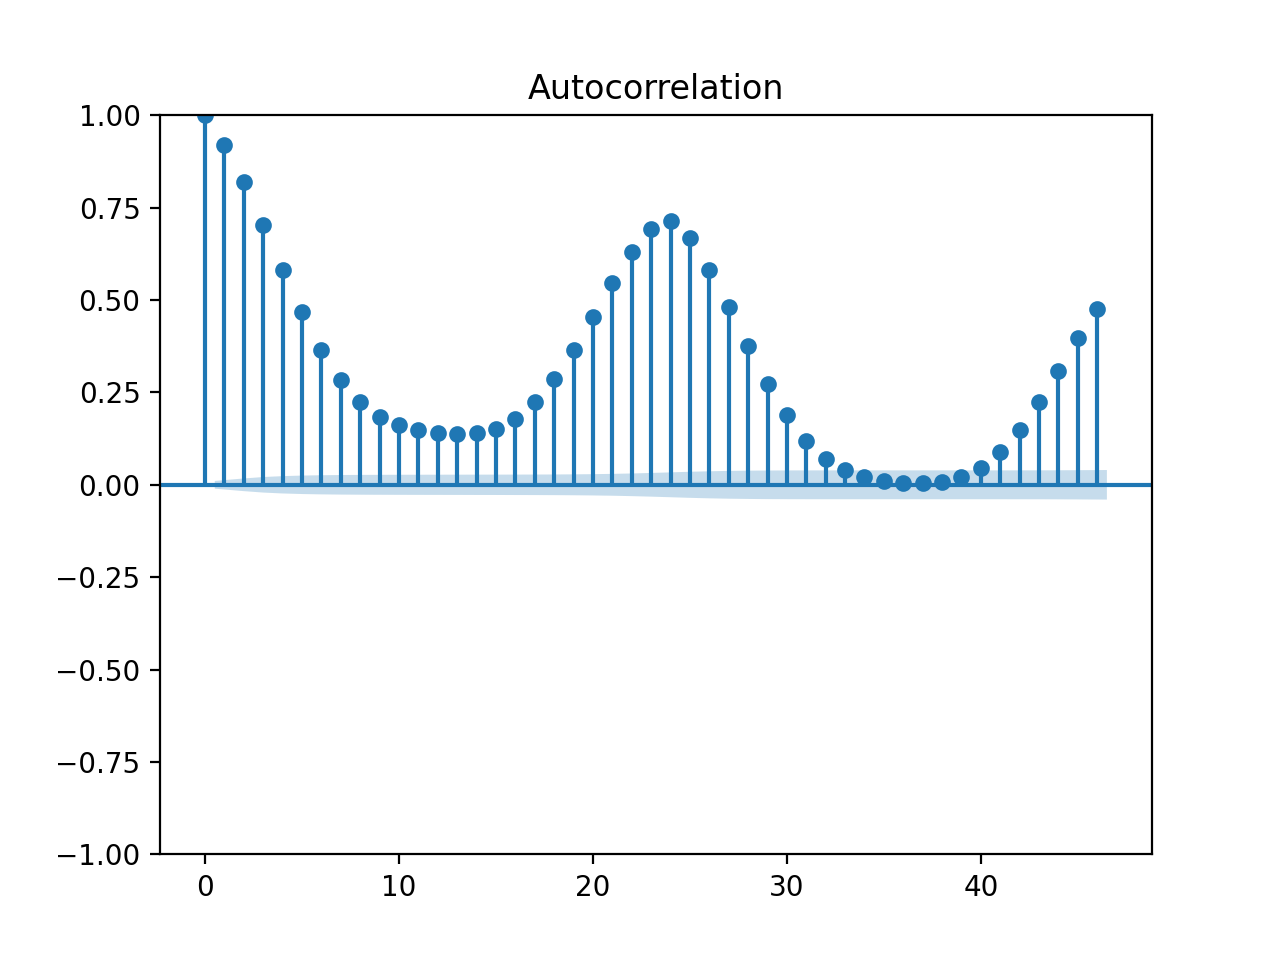

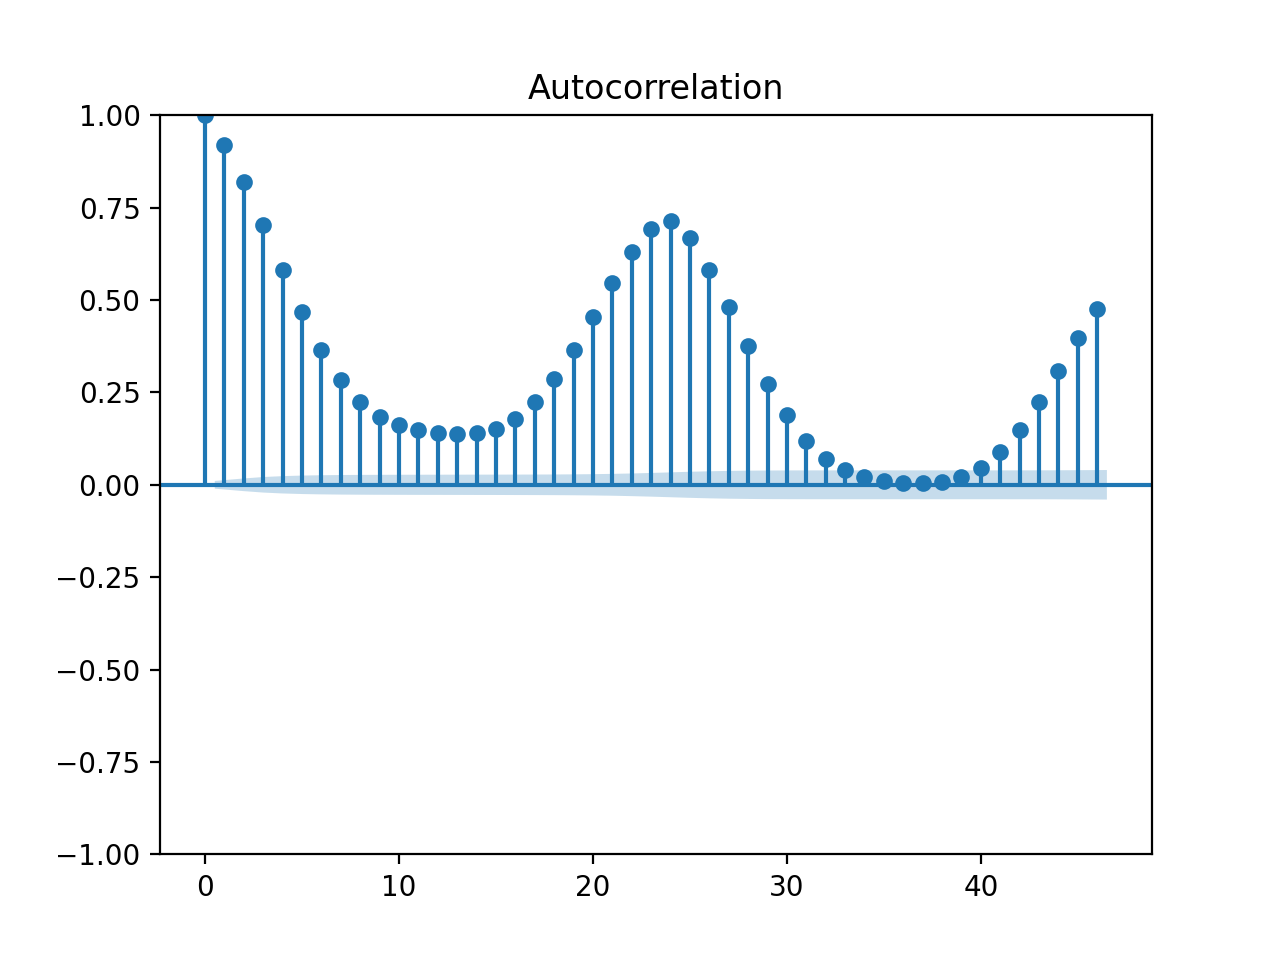

In [ ]:
plot_acf(m2.resid)

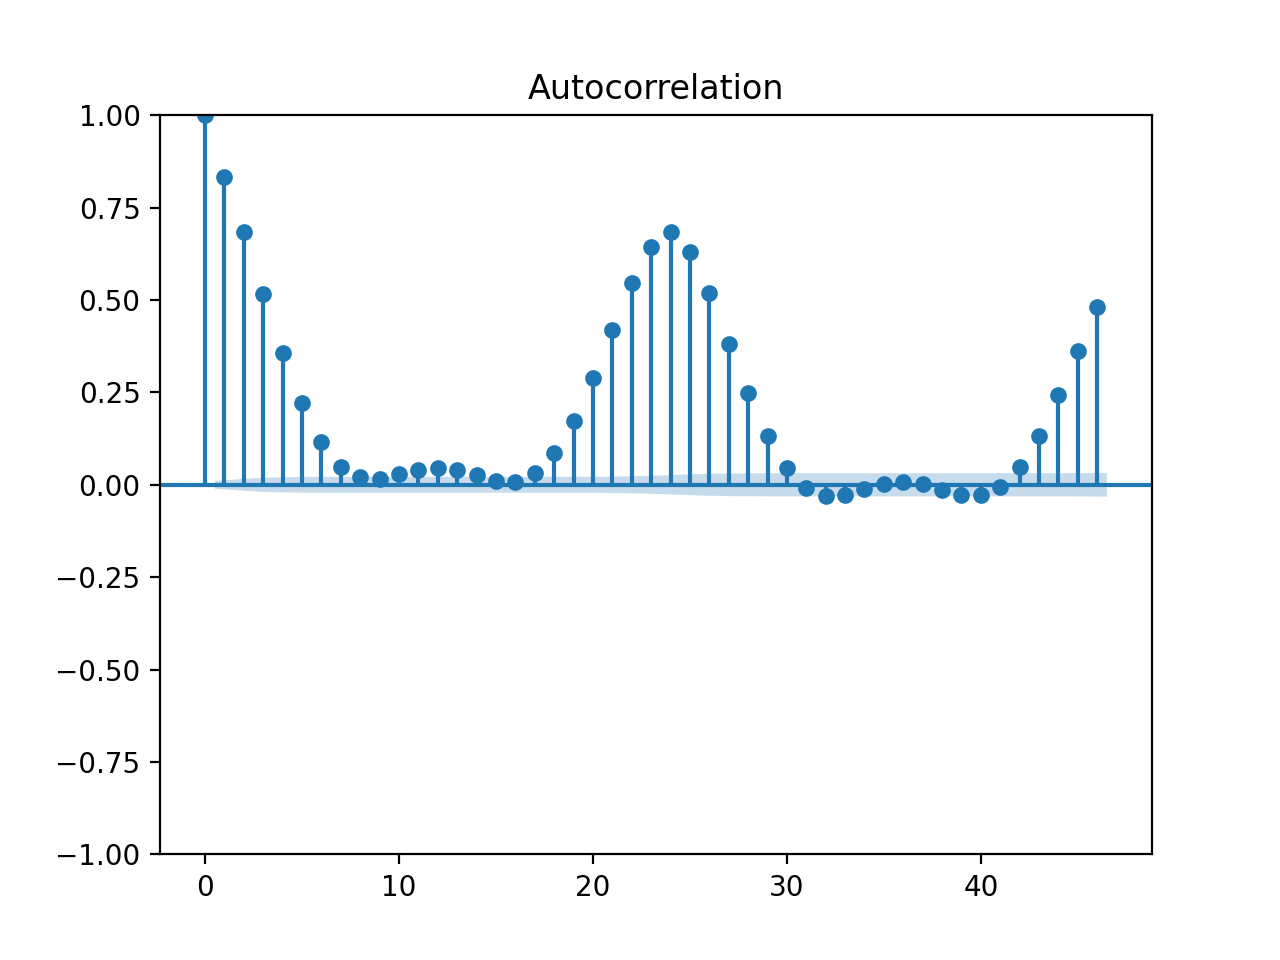

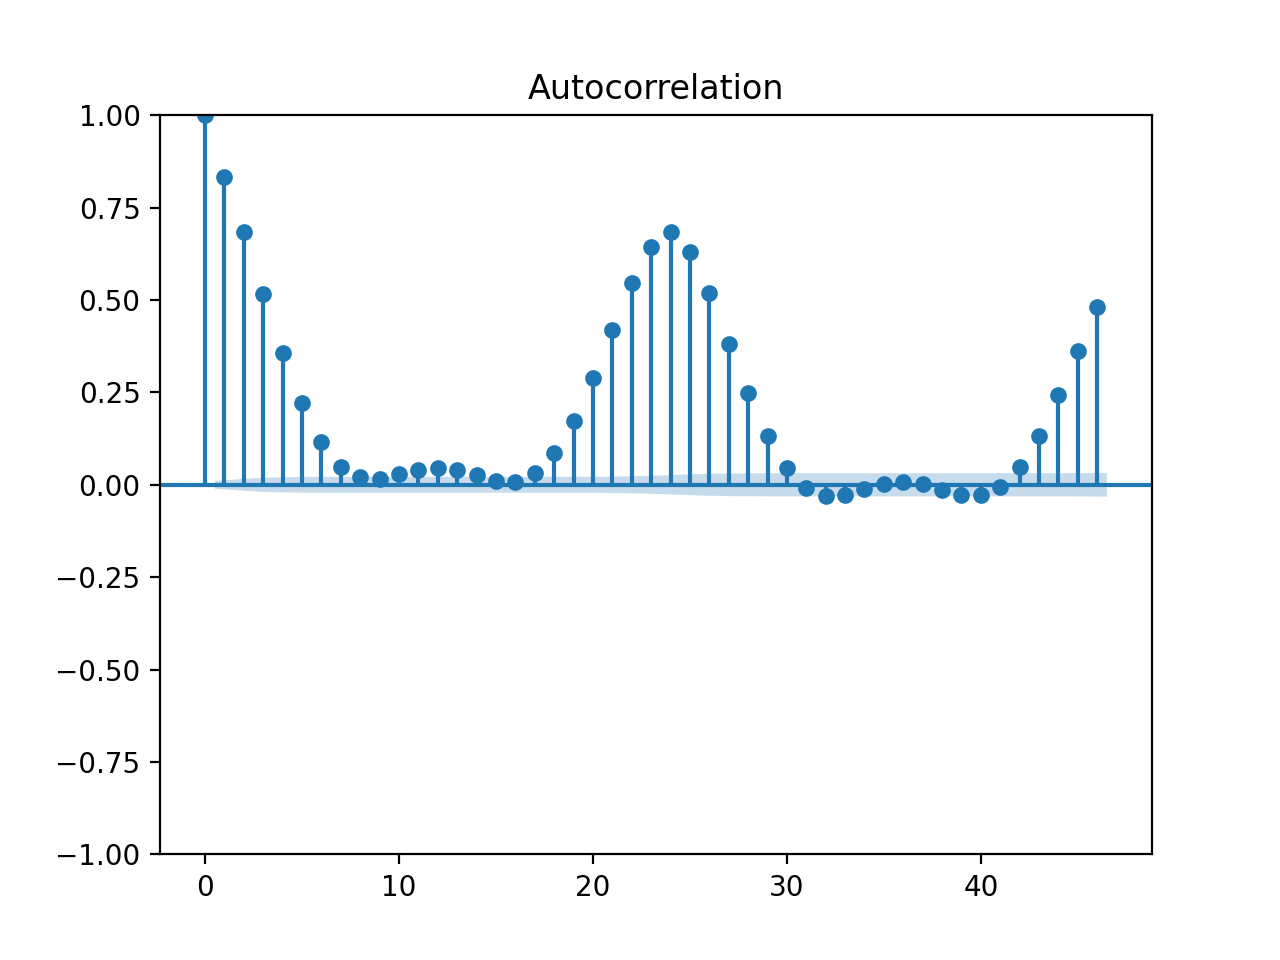

In [ ]:
plot_acf(m3.resid)

# Regression Model Testing

In [ ]:
# model testing
df_test = df.iloc[:26304,:]

test_pred1 = m3.get_prediction(df_test)
test_pred2 = m2.get_prediction(df_test)
test_pred3 = m1.get_prediction(df_test)

In [ ]:
df_test.columns.values

array(['Tavg', 'Tmed', 'Tmax', 'Tmin', 'Load'], dtype=object)

In [ ]:
df_test['fitted_m3'] = test_pred1.predicted_mean
df_test['fitted_m2'] = test_pred2.predicted_mean
df_test['fitted_m1'] = test_pred3.predicted_mean

df_test.tail()

<ipython-input-19-2926703b76c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-19-2926703b76c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-19-2926703b76c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Tavg  Tmed  Tmax  Tmin       Load     fitted_m3  \
Hourly                                                                 
2004-12-31 20:00:00    62  63.0  71.0  53.0  1362998.0  9.892520e+05   
2004-12-31 21:00:00    61  61.0  69.0  52.0  1275108.0  1.105656e+06   
2004-12-31 22:00:00    60  61.0  69.0  52.0  1199578.0  9.368358e+05   
2004-12-31 23:00:00    60  59.0  68.0  53.0  1117834.0  1.179172e+06   
2005-01-01 00:00:00    59  59.0  69.0  52.0  1044673.0  1.049418e+06   

                        fitted_m2     fitted_m1  
Hourly                                           
2004-12-31 20:00:00  1.157036e+06  1.249108e+06  
2004-12-31 21:00:00  1.204796e+06  1.207338e+06  
2004-12-31 22:00:00  1.077784e+06  1.216021e+06  
2004-12-31 23:00:00  1.174310e+06  1.198111e+06  
2005-01-01 00:00:00  1.103294e+06  1.238014e+06

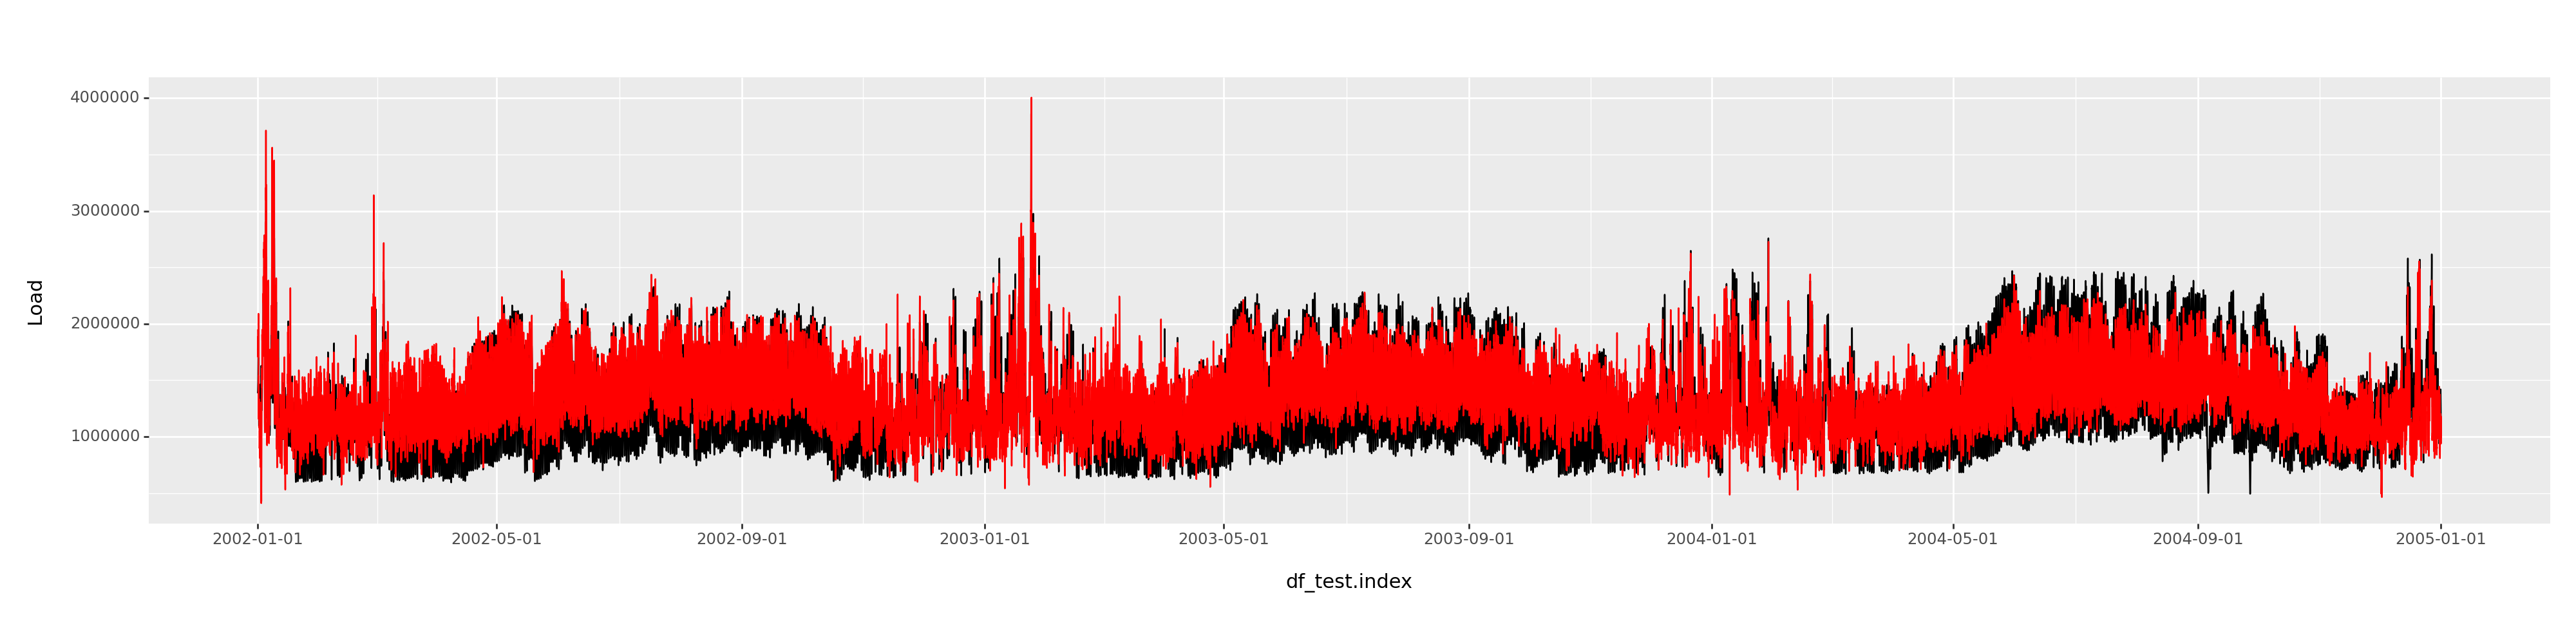

<Figure Size: (2000 x 500)>

In [ ]:
# Visualize the models
ggplot(df_test, aes('df_test.index','Load')) + geom_line() + geom_line(aes('df_test.index', 'fitted_m3'),color='red')+ theme(figure_size=(20,5))

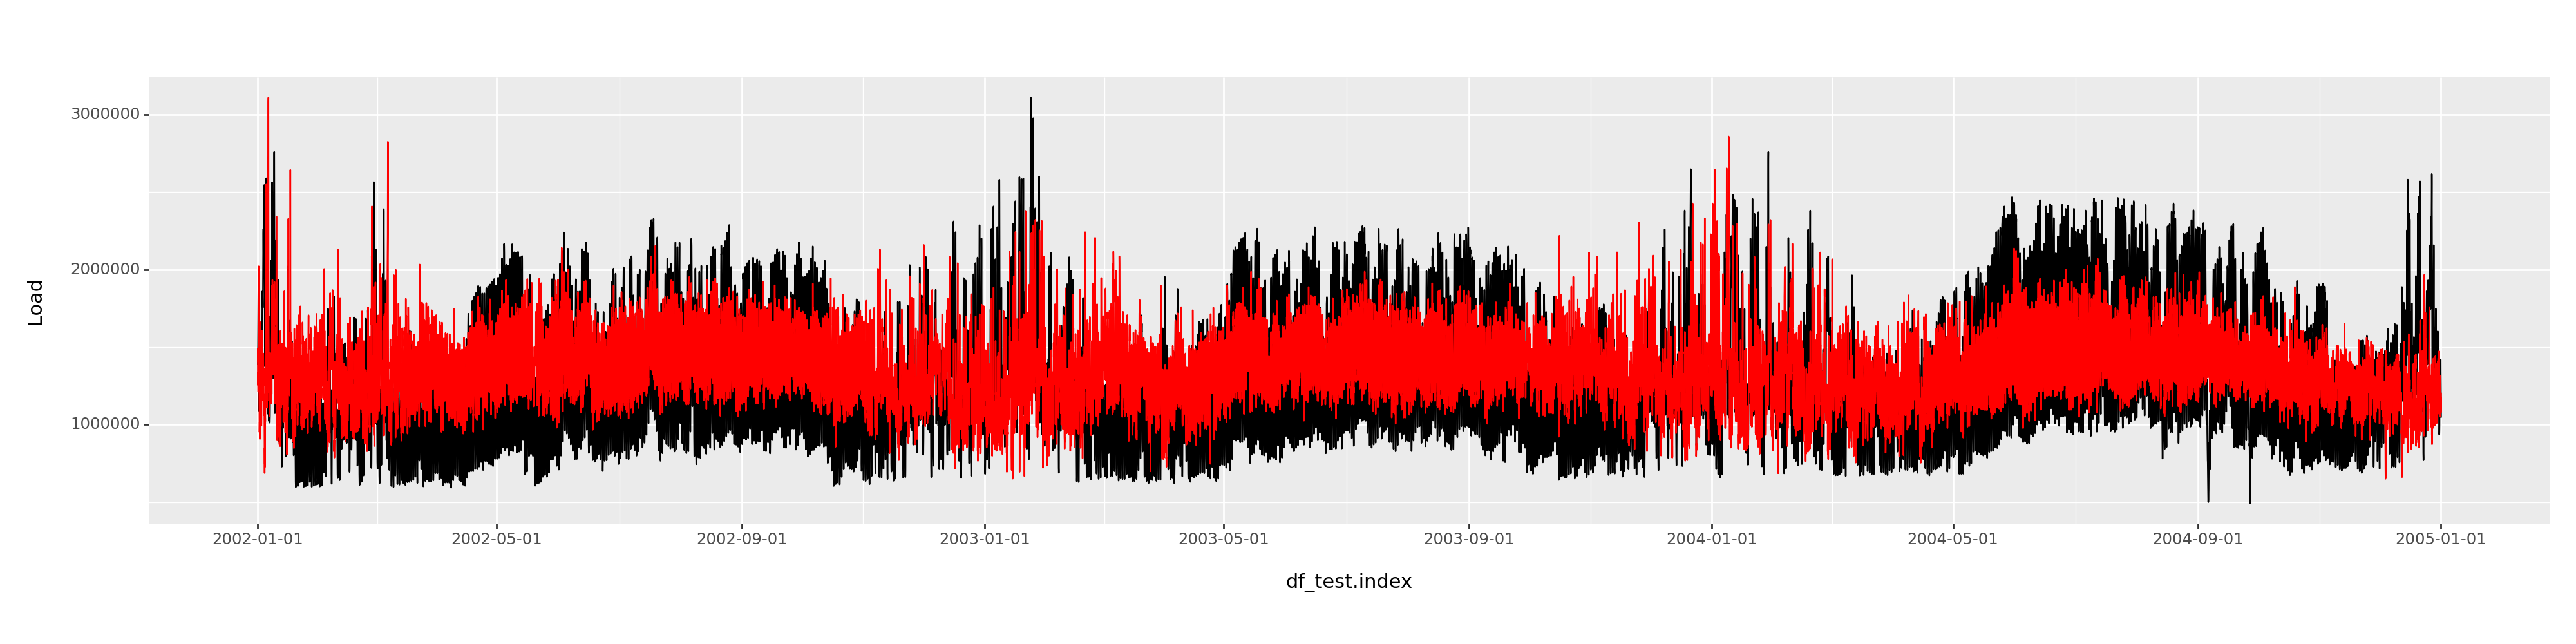

<Figure Size: (2000 x 500)>

In [ ]:
ggplot(df_test, aes('df_test.index','Load')) + geom_line() + geom_line(aes('df_test.index', 'fitted_m2'), color='red')+ theme(figure_size=(20,5))

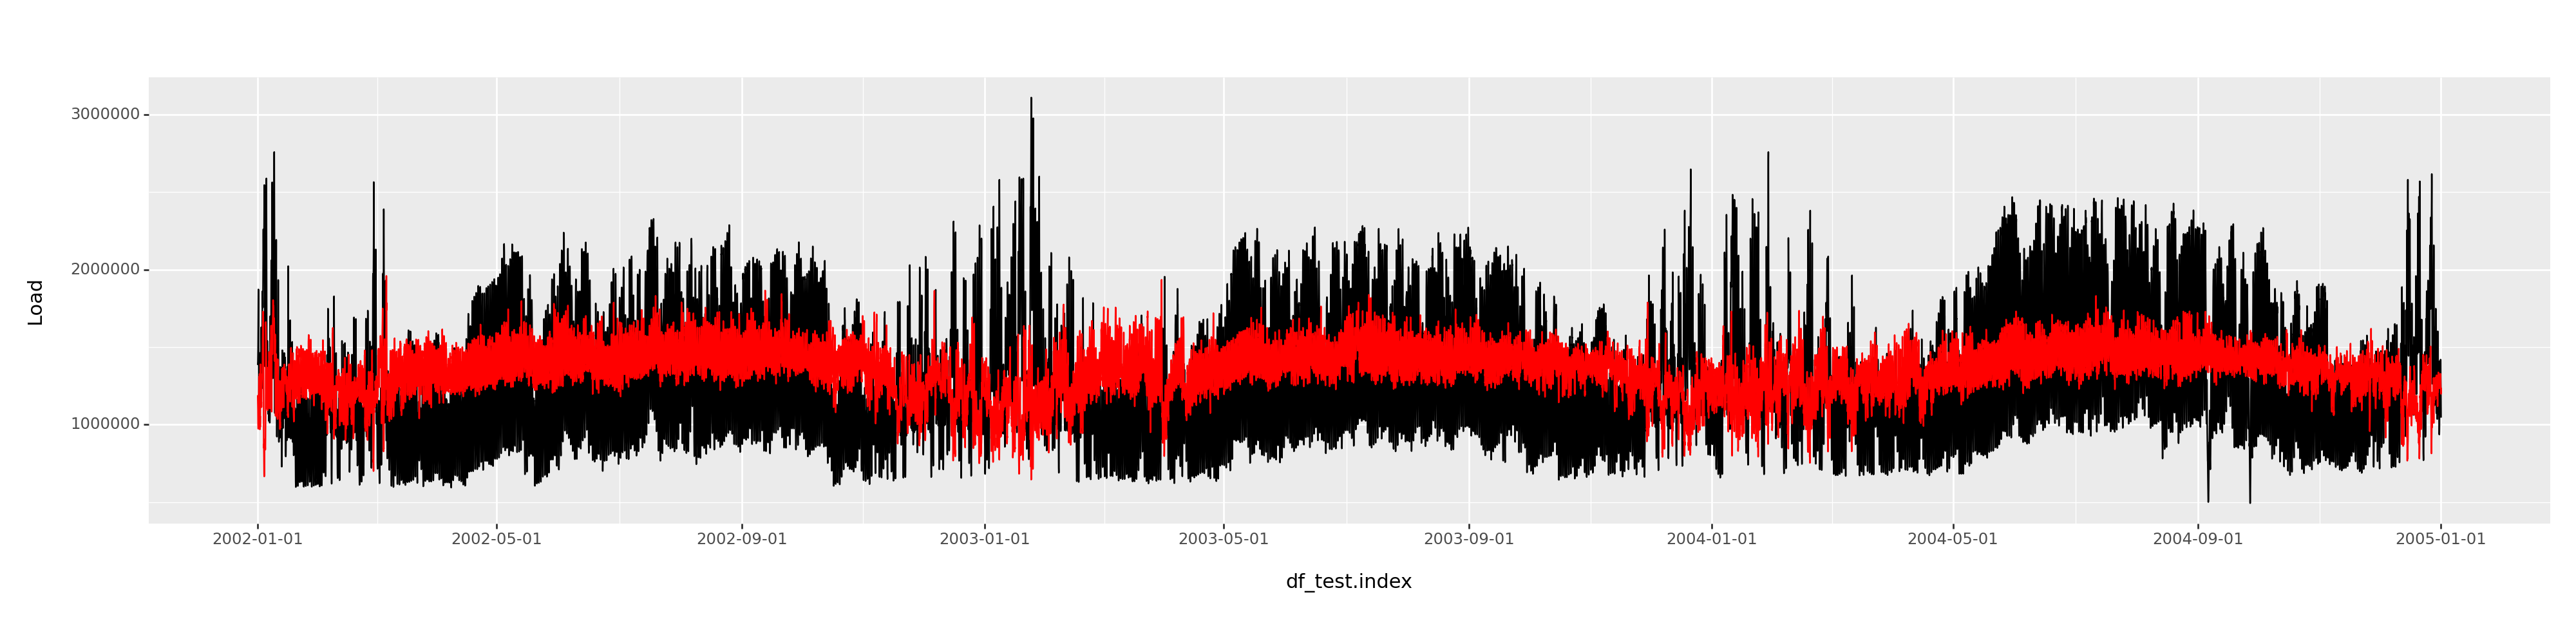

<Figure Size: (2000 x 500)>

In [ ]:
ggplot(df_test, aes('df_test.index','Load')) + geom_line() + geom_line(aes('df_test.index', 'fitted_m1'), color='red')+ theme(figure_size=(20,5))

In [ ]:
#Calculate MAPE of predictions, first create function to make it easier
#def calculate_mape(actual, predicted):
 #   return 100 * np.mean(np.abs((actual - predicted) / actual))
 #oops forgot there was a library with a function for that already

In [ ]:
#Model 3 MAPE
mape3 = 100* mean_absolute_percentage_error(df_test['Load'],df_test['fitted_m3'])
print("MAPE: {:.2f}%".format(mape3))

MAPE: 18.86%


In [ ]:
#Model 2 MAPE
mape2 = 100* mean_absolute_percentage_error(df_test['Load'],df_test['fitted_m2'])
print("MAPE: {:.2f}%".format(mape2))

MAPE: 24.33%


In [ ]:
#Model 1 MAPE
mape1 = 100* mean_absolute_percentage_error(df_test['Load'],df_test['fitted_m1'])
print("MAPE: {:.2f}%".format(mape1))

MAPE: 26.51%


In [ ]:
df.index

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2006-12-31 15:00:00', '2006-12-31 16:00:00',
               '2006-12-31 17:00:00', '2006-12-31 18:00:00',
               '2006-12-31 19:00:00', '2006-12-31 20:00:00',
               '2006-12-31 21:00:00', '2006-12-31 22:00:00',
               '2006-12-31 23:00:00', '2007-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Hourly', length=43824, freq=None)

# Data Outlier Check

<Axes: ylabel='Frequency'>

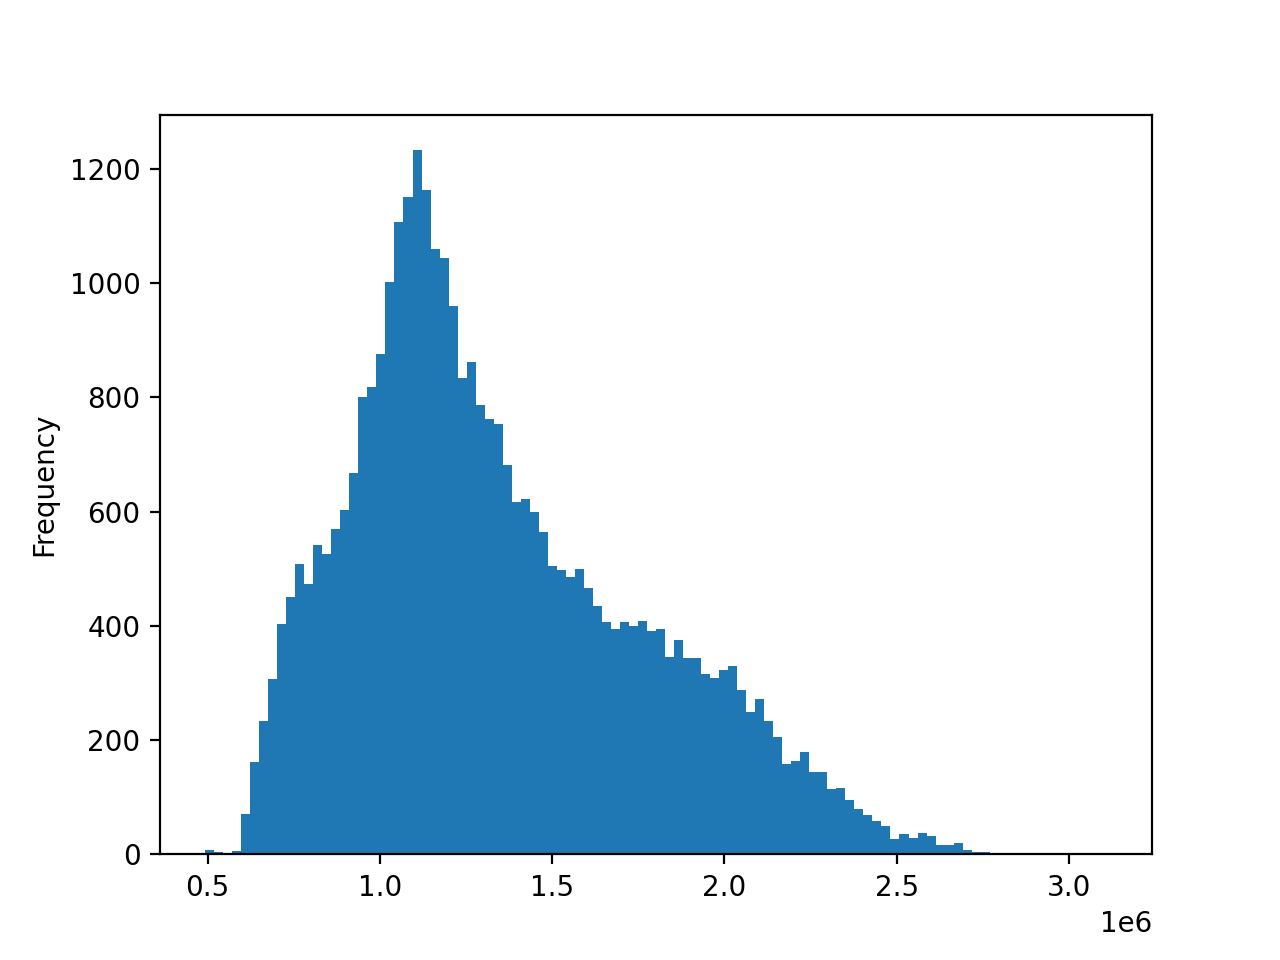

In [ ]:
#data analysis
df['Load'].plot(kind='hist', bins=100)

<Axes: title={'center': 'Outliers'}, xlabel='Hourly'>

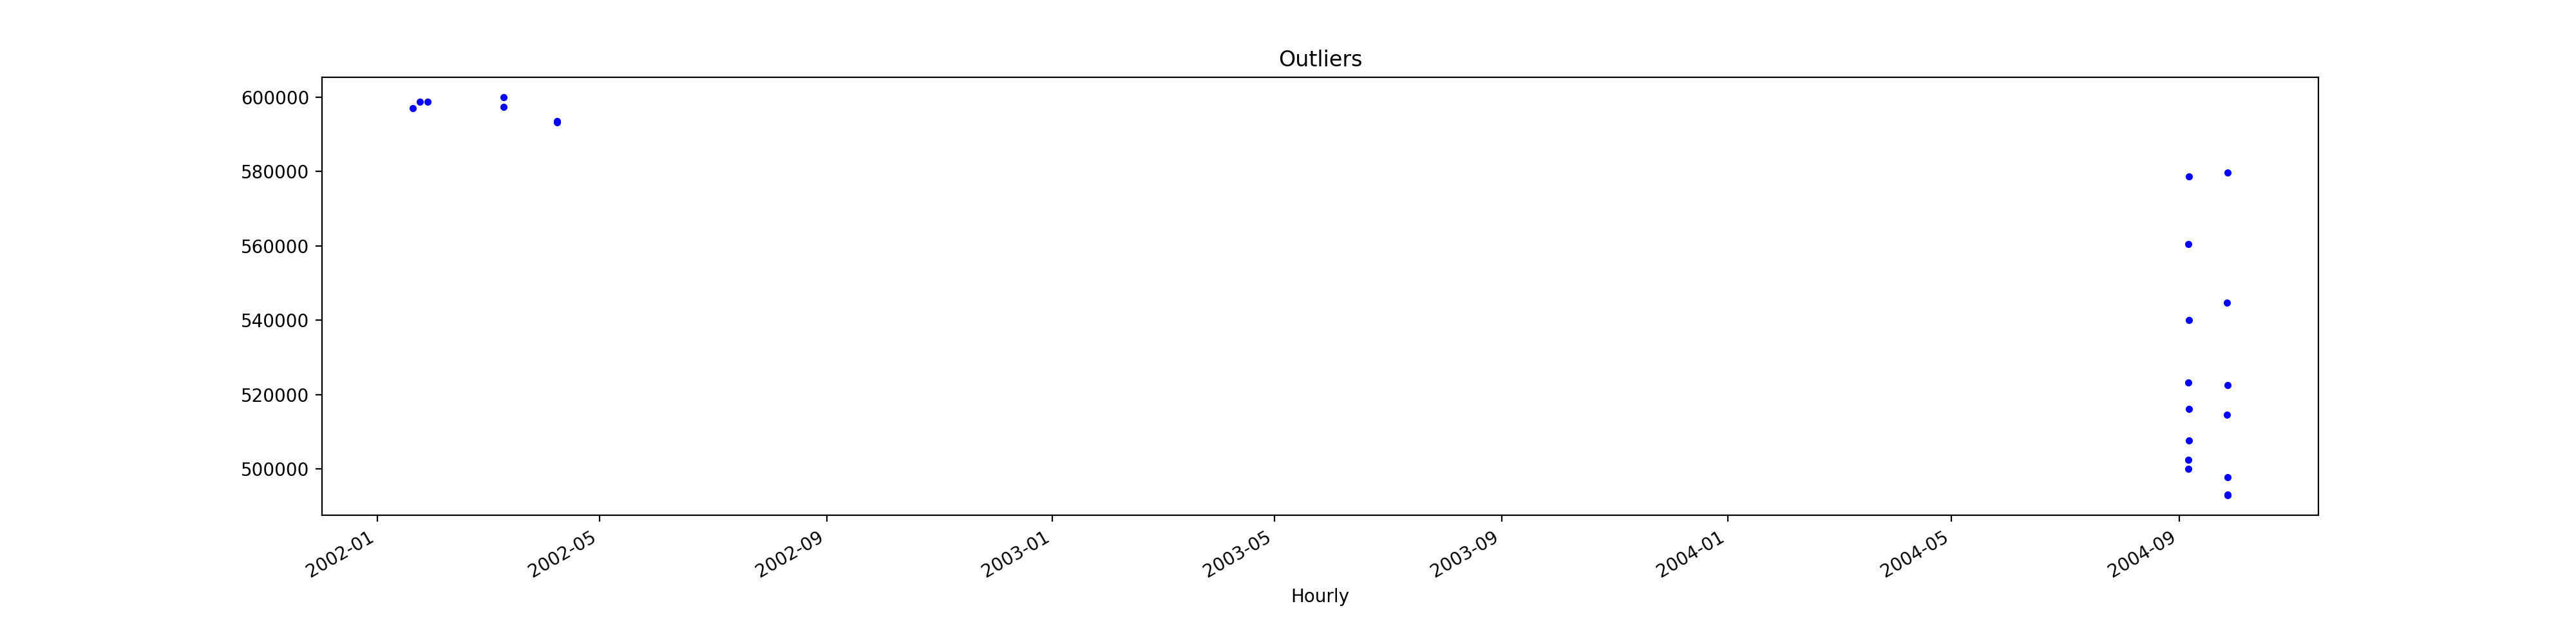

In [ ]:
df.query('Load < 600000')['Load'] \
    .plot(style='.',
          figsize=(20, 5),
          color='blue',
          title='Outliers')

In [ ]:
#removing the lower bound outliers from the data
#df = df.query('Load > 600000').copy()
#tried to remove outlier but when i was testing my mape went up to 8%?

# Gradient Boosted Tree Prediction Model Setup

In [ ]:
#xgboost model
train = df.loc[df.index < '2005-01-01']
test = df.loc[(df.index >= '2005-01-01')&(df.index < '2006-01-01')]
future = df.loc[(df.index > '2006-01-01')]

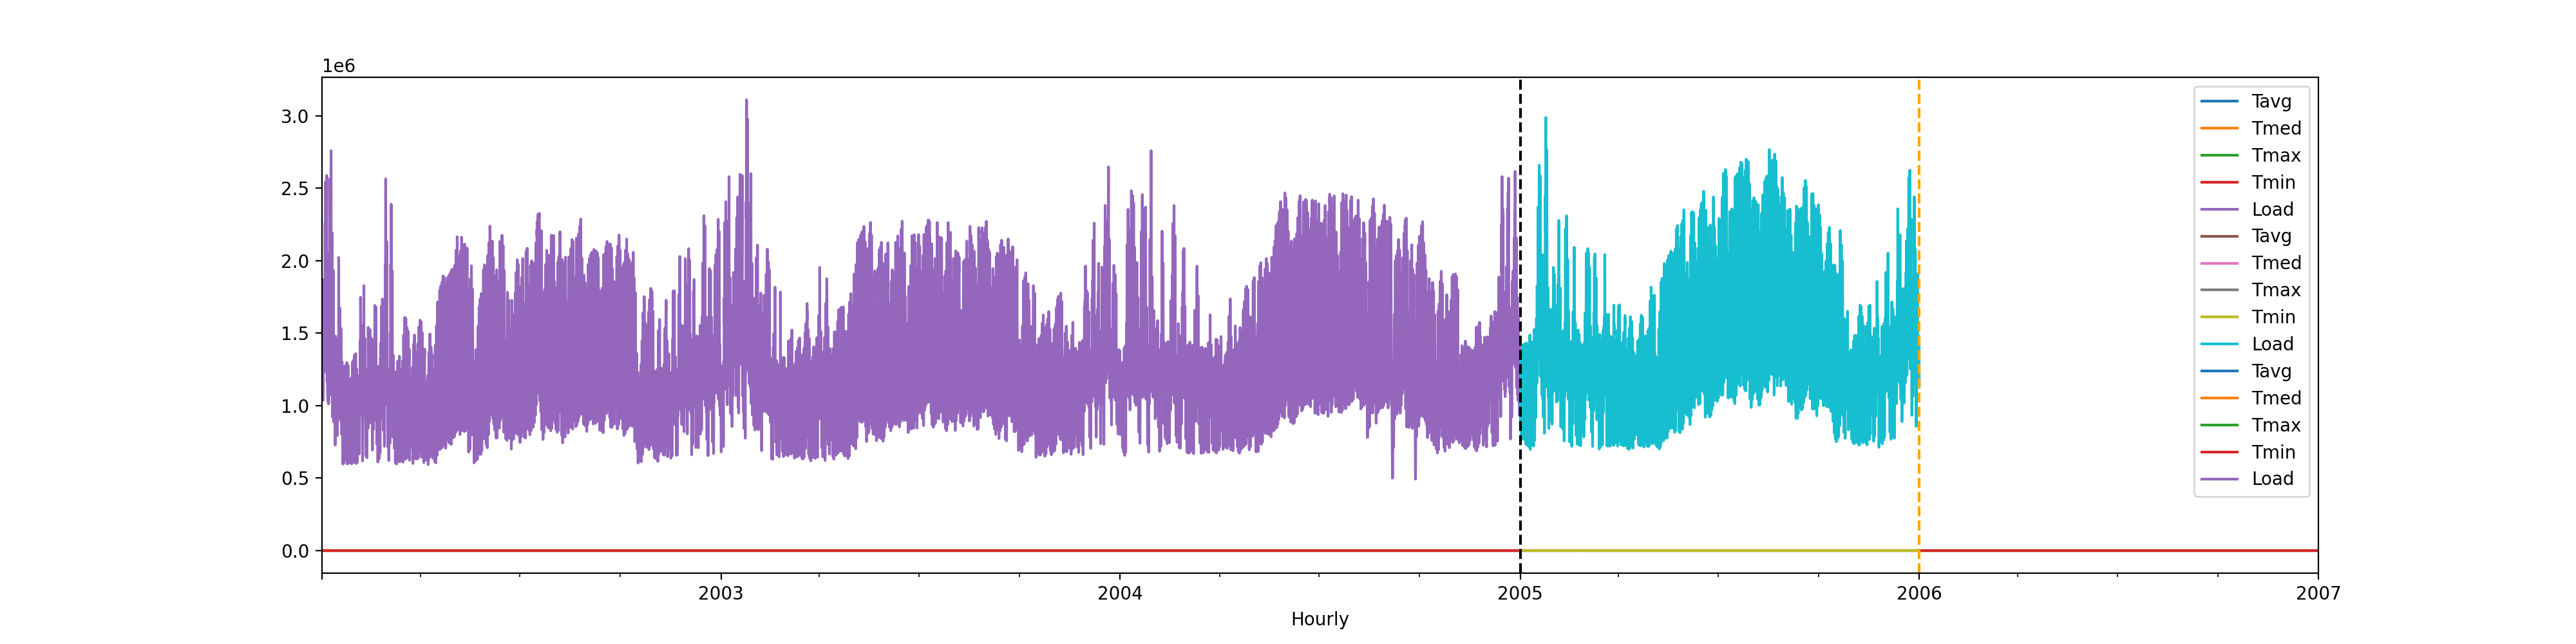

In [ ]:
#plot the training and testing set to check if it works
fig, ax = plt.subplots(figsize=(20,5))
train.plot(ax=ax,label='Training')
test.plot(ax=ax,label='Testing')
future.plot(ax=ax,label='Future')
ax.axvline('2005-01-01',color ='black',ls='--')
ax.axvline('2006-01-01',color ='orange',ls='--')
plt.show()

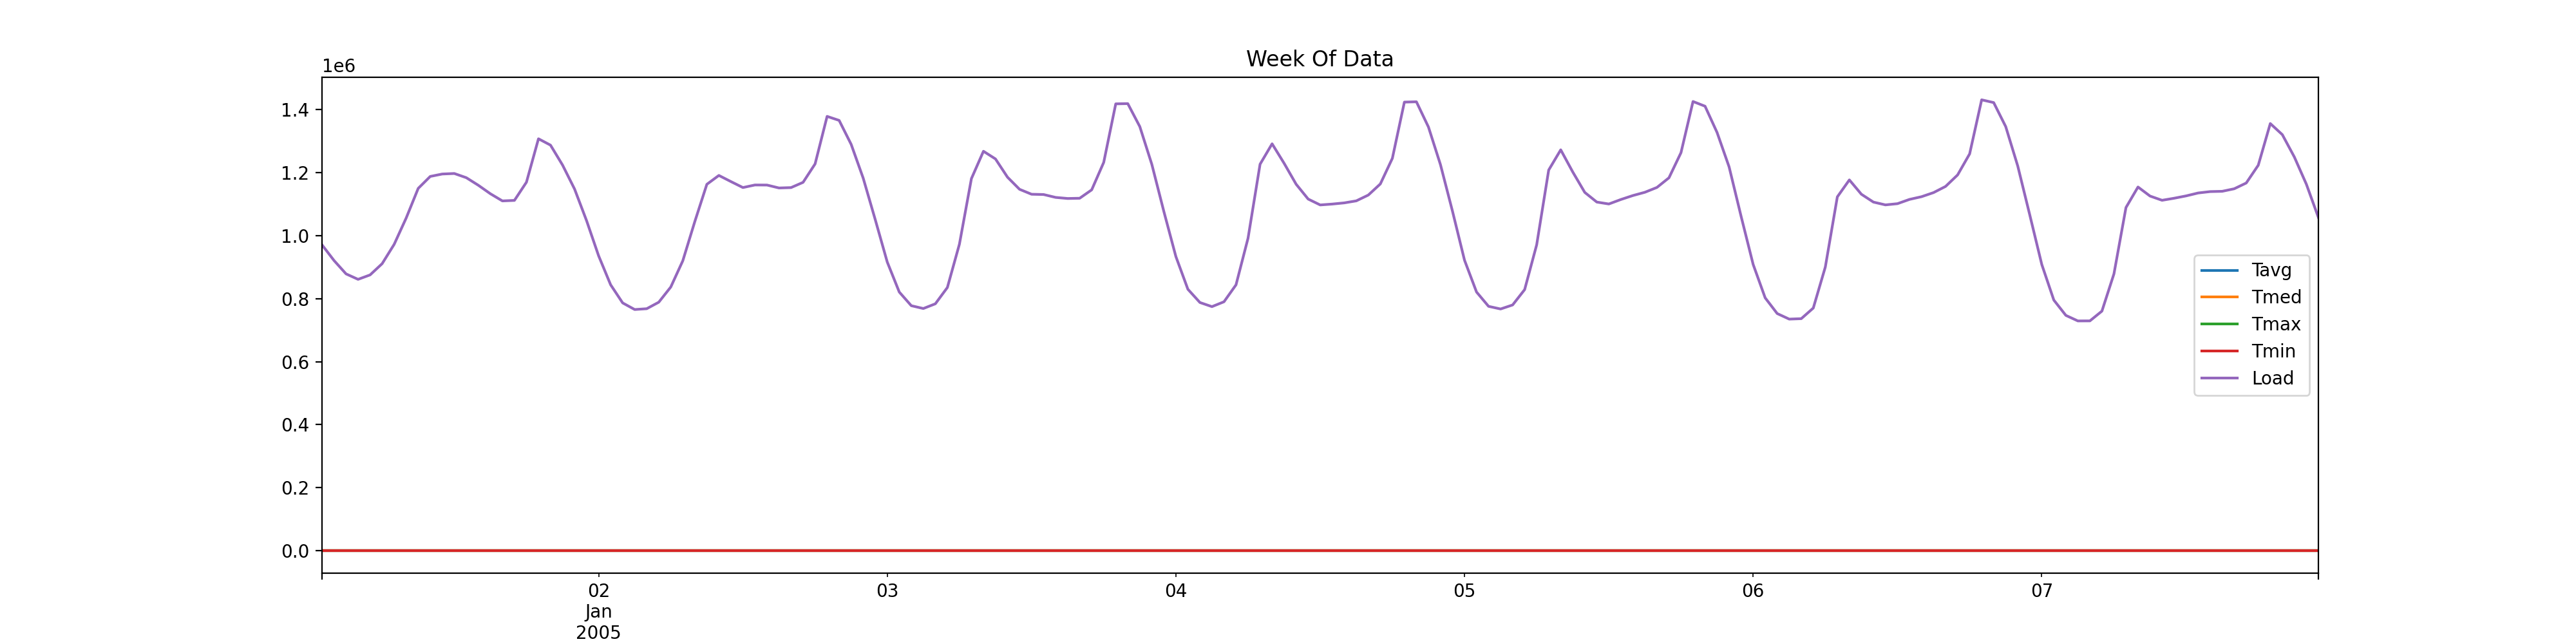

In [ ]:
#check what a week of data looks like
df.loc[(df.index > '2005-01-01') & (df.index < '2005-01-08')] \
.plot(figsize=(20, 5), title='Week Of Data')
plt.show()

# More Data Visualizations

In [ ]:
#create some features based on time series index
#this function will create features and add them to the specified data frame
#the df.copy() line is there to allow use with the xgbregressor model later
def create_features(df):
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week
  return df

df = create_features(df)

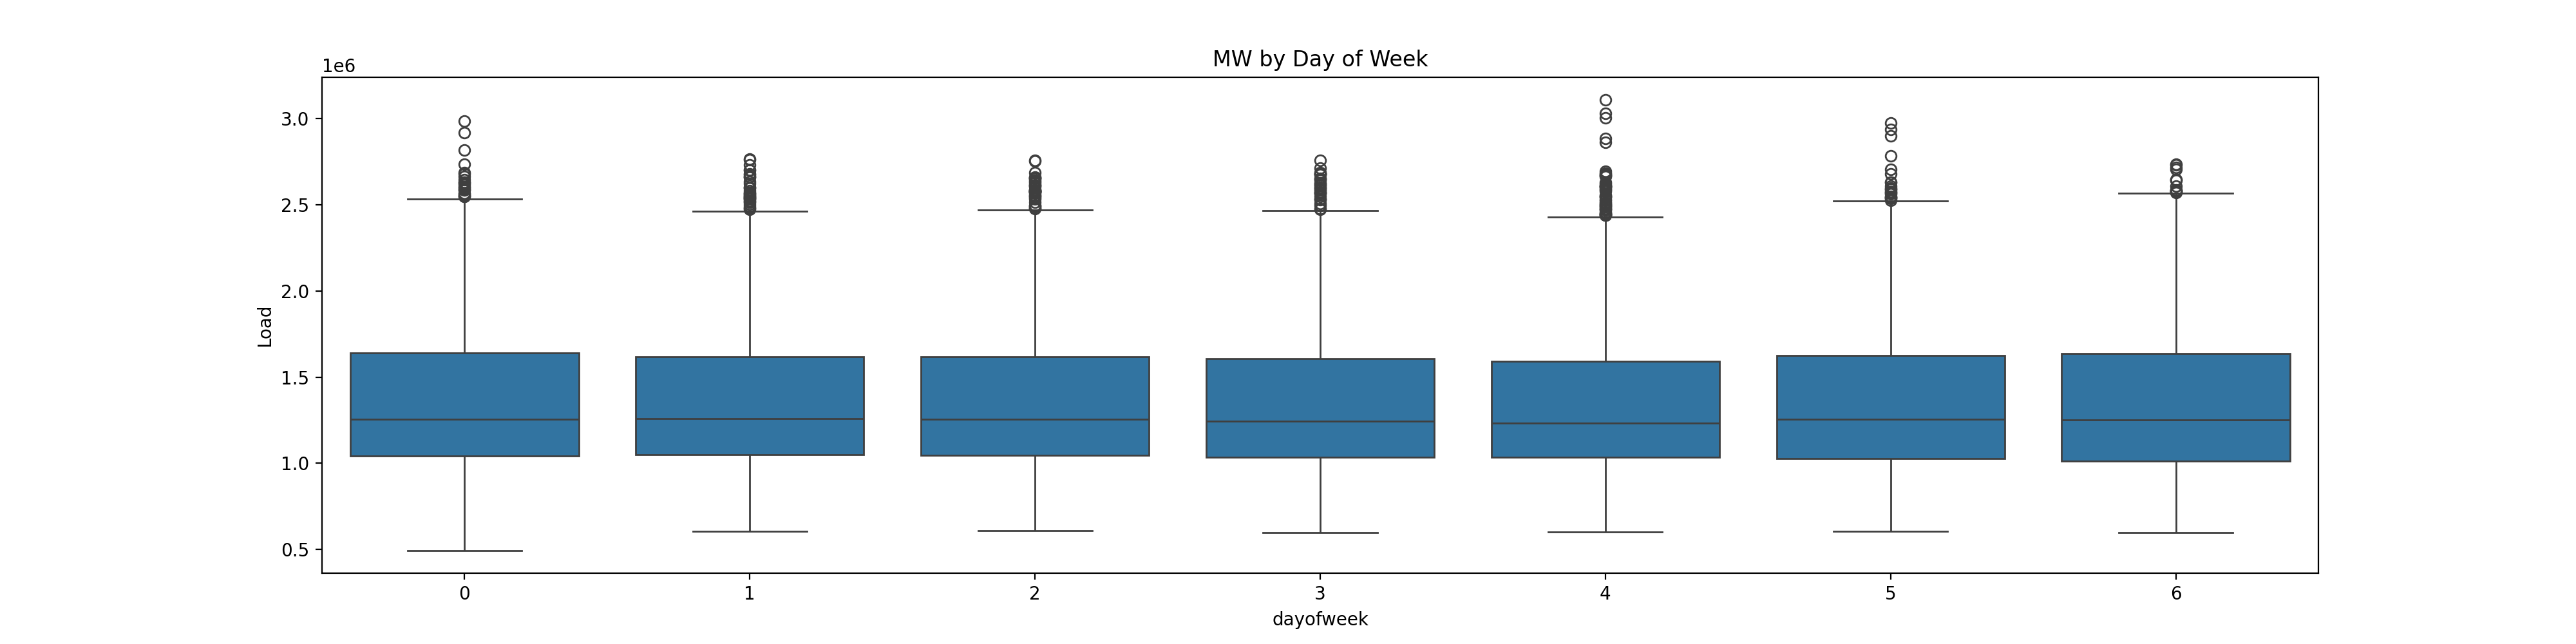

In [ ]:
#Visualize the day of week feature
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df, x='dayofweek', y='Load')
ax.set_title('MW by Day of Week')
plt.show()

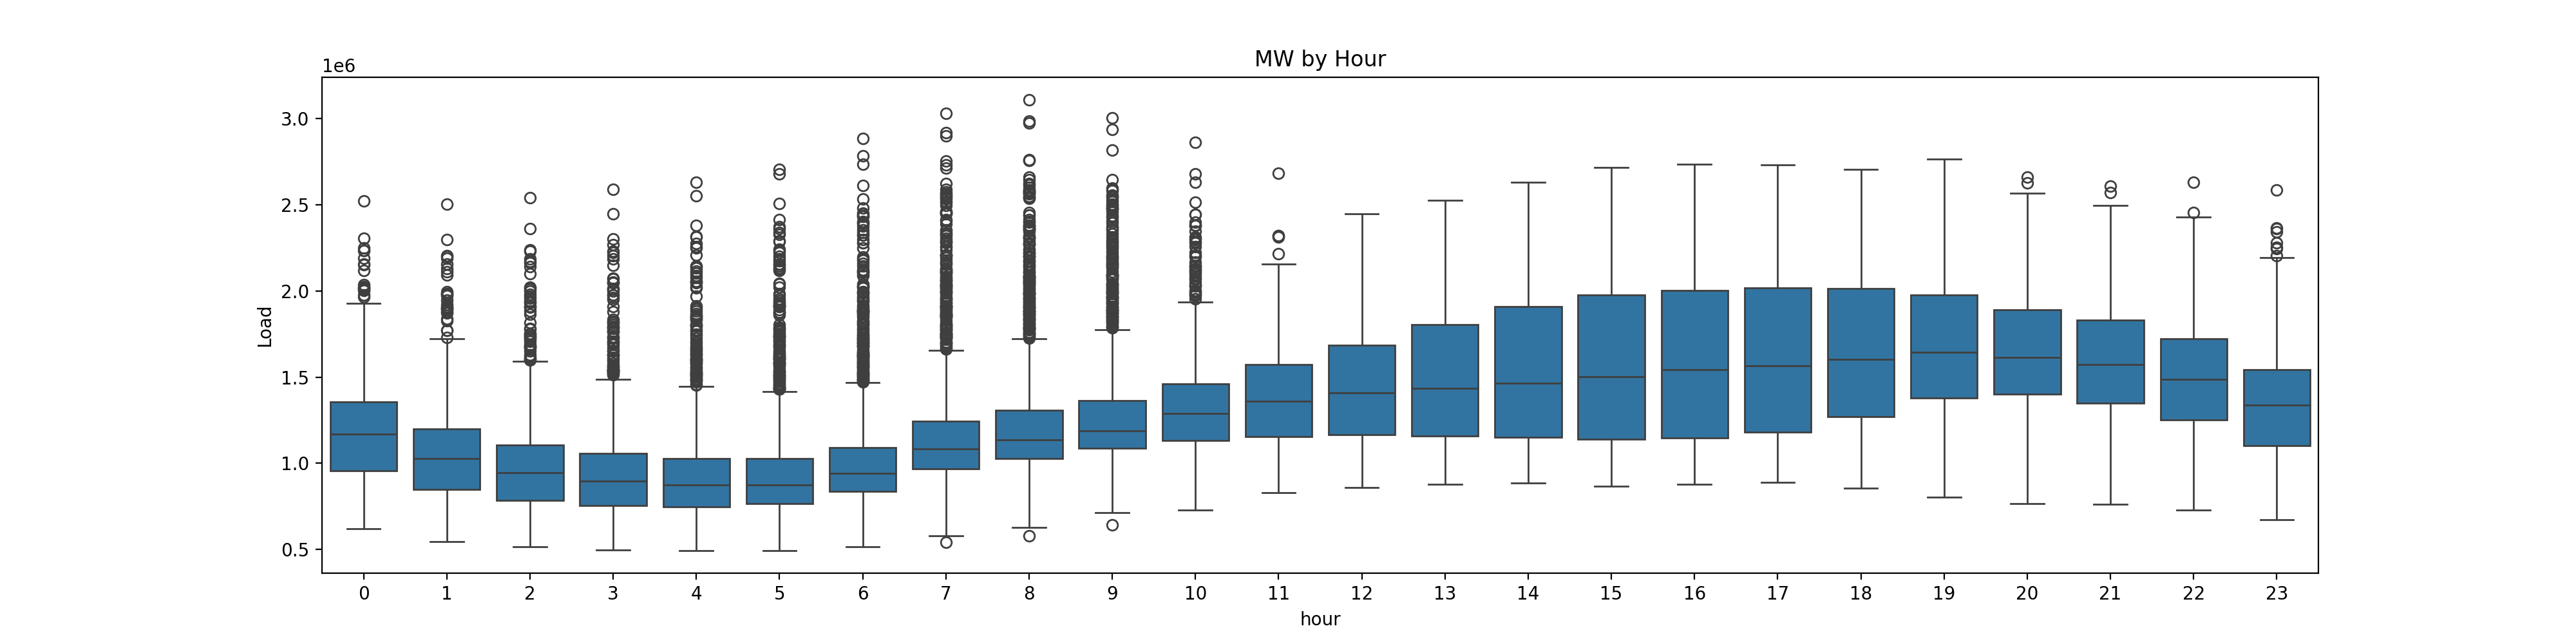

In [ ]:
#Visualize the hour feature
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df, x='hour', y='Load')
ax.set_title('MW by Hour')
plt.show()

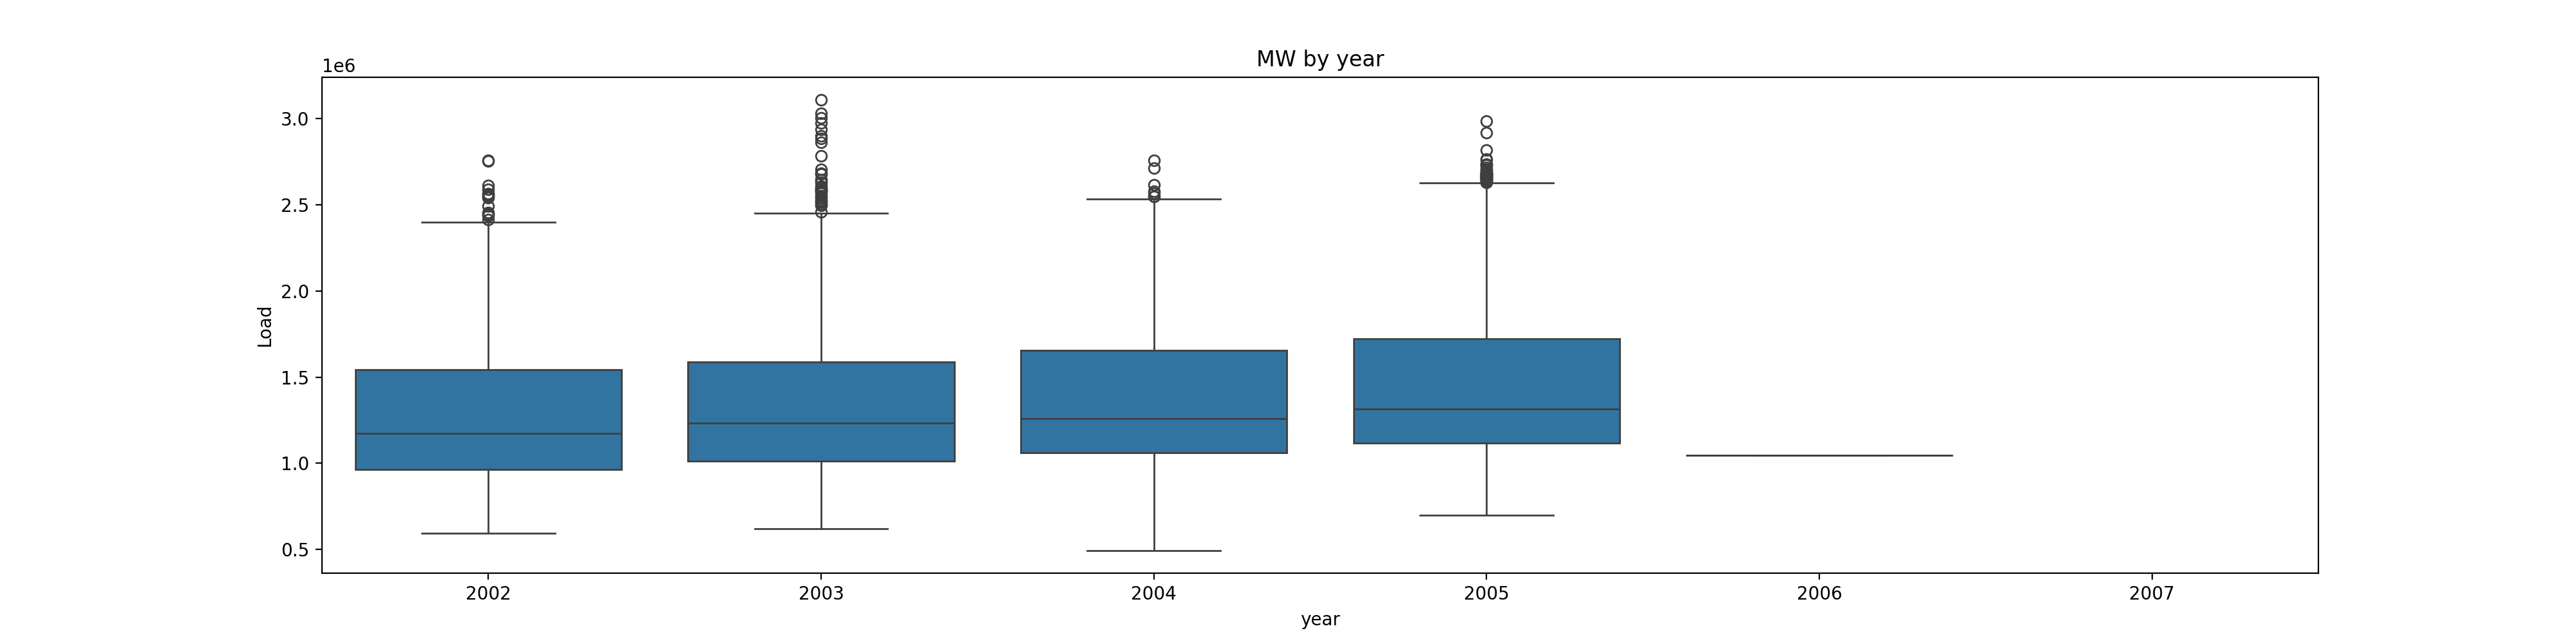

In [ ]:
#Visualize the year feature
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df, x='year', y='Load')
ax.set_title('MW by year')
plt.show()

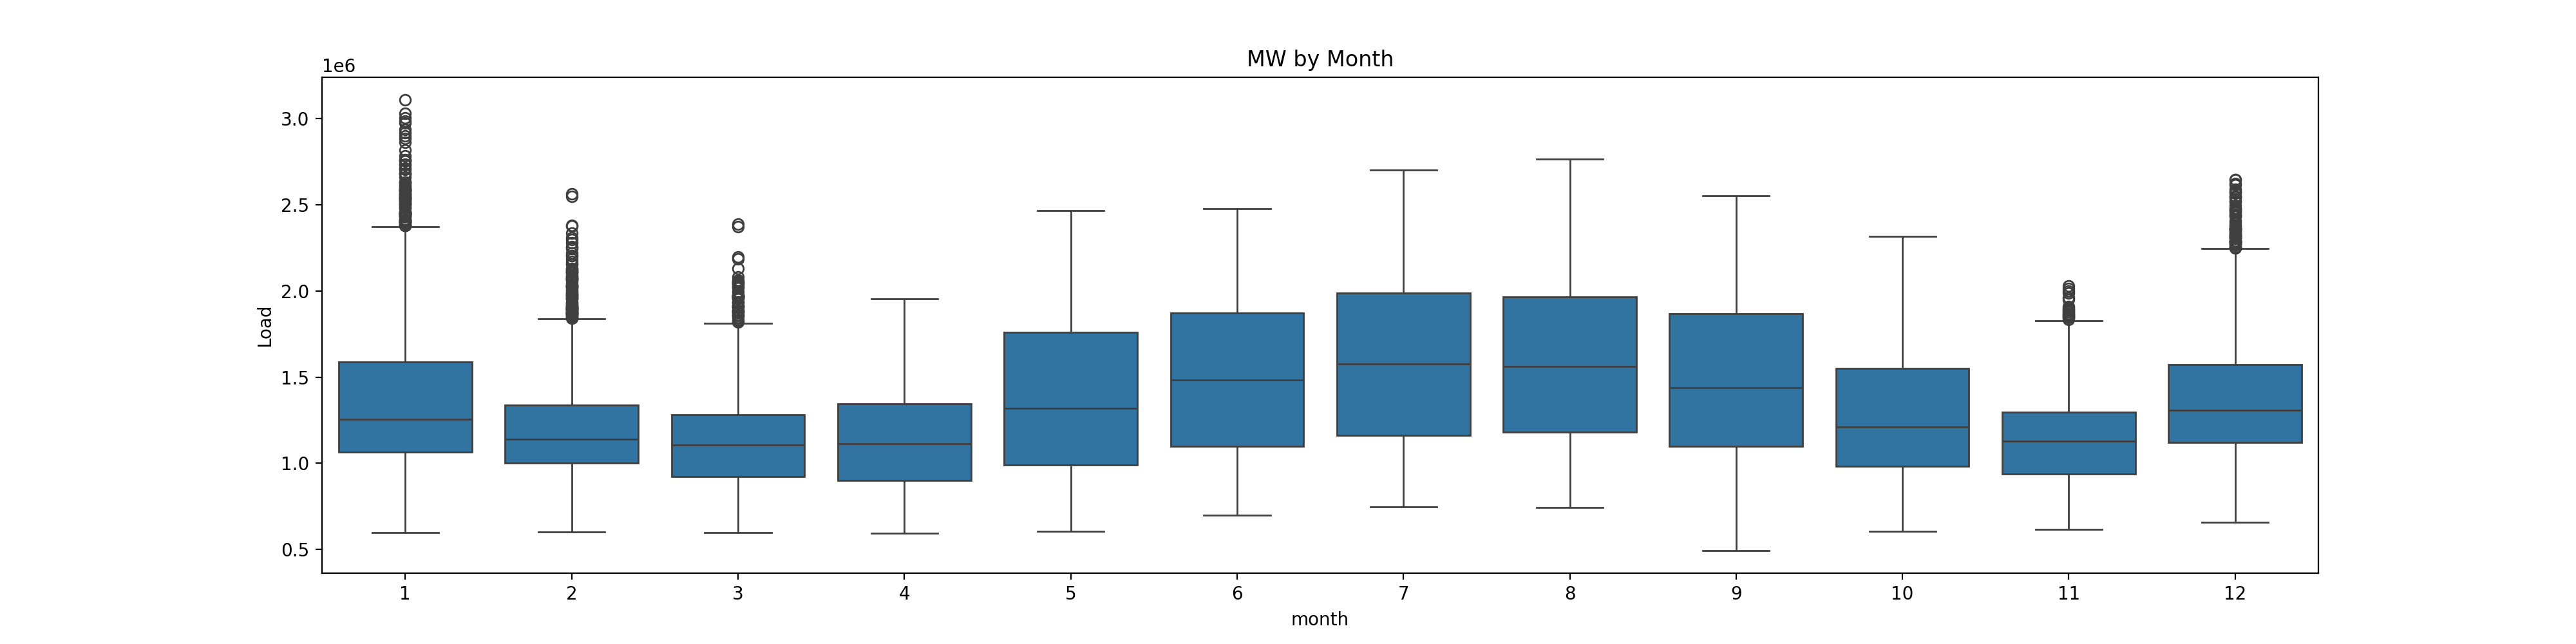

In [ ]:
#Visualize the month feature
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=df, x='month', y='Load')
ax.set_title('MW by Month')
plt.show()

In [ ]:
df.tail()

Tavg  Tmed  Tmax  Tmin  Load  hour  dayofweek  quarter  \
Hourly                                                                        
2006-12-31 20:00:00    71  72.0  77.0  65.0   NaN    20          6        4   
2006-12-31 21:00:00    70  72.0  75.0  65.0   NaN    21          6        4   
2006-12-31 22:00:00    70  71.0  75.0  65.0   NaN    22          6        4   
2006-12-31 23:00:00    69  70.0  74.0  65.0   NaN    23          6        4   
2007-01-01 00:00:00    69  70.0  73.0  64.0   NaN     0          0        1   

                     month  year  dayofyear  dayofmonth  weekofyear  
Hourly                                                               
2006-12-31 20:00:00     12  2006        365          31          52  
2006-12-31 21:00:00     12  2006        365          31          52  
2006-12-31 22:00:00     12  2006        365          31          52  
2006-12-31 23:00:00     12  2006        365          31          52  
2007-01-01 00:00:00      1  2007          1           1           1

# Gradient Boosted Tree Model

In [ ]:
#xgboost info:
#helpful documentation
#https://xgboost.readthedocs.io/en/stable/python/python_api.html
#how the model works
#https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4
#youtube explanation of the algorithm
#https://www.youtube.com/watch?v=3CC4N4z3GJc

In [ ]:
#create the xgboost model
#adding features to a training and testing copy of our data frame as well as the eventual future prediction dataframe
train = create_features(train)
test = create_features(test)
future = create_features(future)

#creating separate feature and target data set for use with the model
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','Tavg','Tmed','Tmax','Tmin']
TARGET = 'Load'

#creating a data set that contains the correct data for training,testing,and future predictions and includes the features and specifies the target to predict for ease of use in the model
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_future = future[FEATURES]
y_future = future[TARGET]

In [ ]:
#the actual model
#booster indicates what type of algorithm to use, we are gonna use gradient boosted trees
#n_estimators is the amount of different decision trees it will go through to create the best model
#early_stopping_rounds tells the model to stop after a specified amount of rounds with no improvement
#learning_rate adjusts how quickly the model fits to the data, a lower learning rate is used to stop the model from instantly overfitting data by multiplying itself with the residuals of predictions and thus reducing
#the training predictions and causing the model to continue to look for for trees to get closer to the actual value that it is trained against
reg = xgb.XGBRegressor(
                       base_score=0.5,
                       booster='gbtree',
                       n_estimators=4000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       eval_metric = 'mape',
                       max_depth=3,
                       learning_rate=0.01)
#verbose changes how often it shows model results
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=400)

[0]	validation_0-mape:0.98971	validation_1-mape:0.99054
[400]	validation_0-mape:0.07607	validation_1-mape:0.09187
[800]	validation_0-mape:0.06232	validation_1-mape:0.07146
[1200]	validation_0-mape:0.05617	validation_1-mape:0.06707
[1600]	validation_0-mape:0.05308	validation_1-mape:0.06570
[2000]	validation_0-mape:0.05066	validation_1-mape:0.06470
[2400]	validation_0-mape:0.04919	validation_1-mape:0.06434
[2800]	validation_0-mape:0.04798	validation_1-mape:0.06389
[2994]	validation_0-mape:0.04744	validation_1-mape:0.06382


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

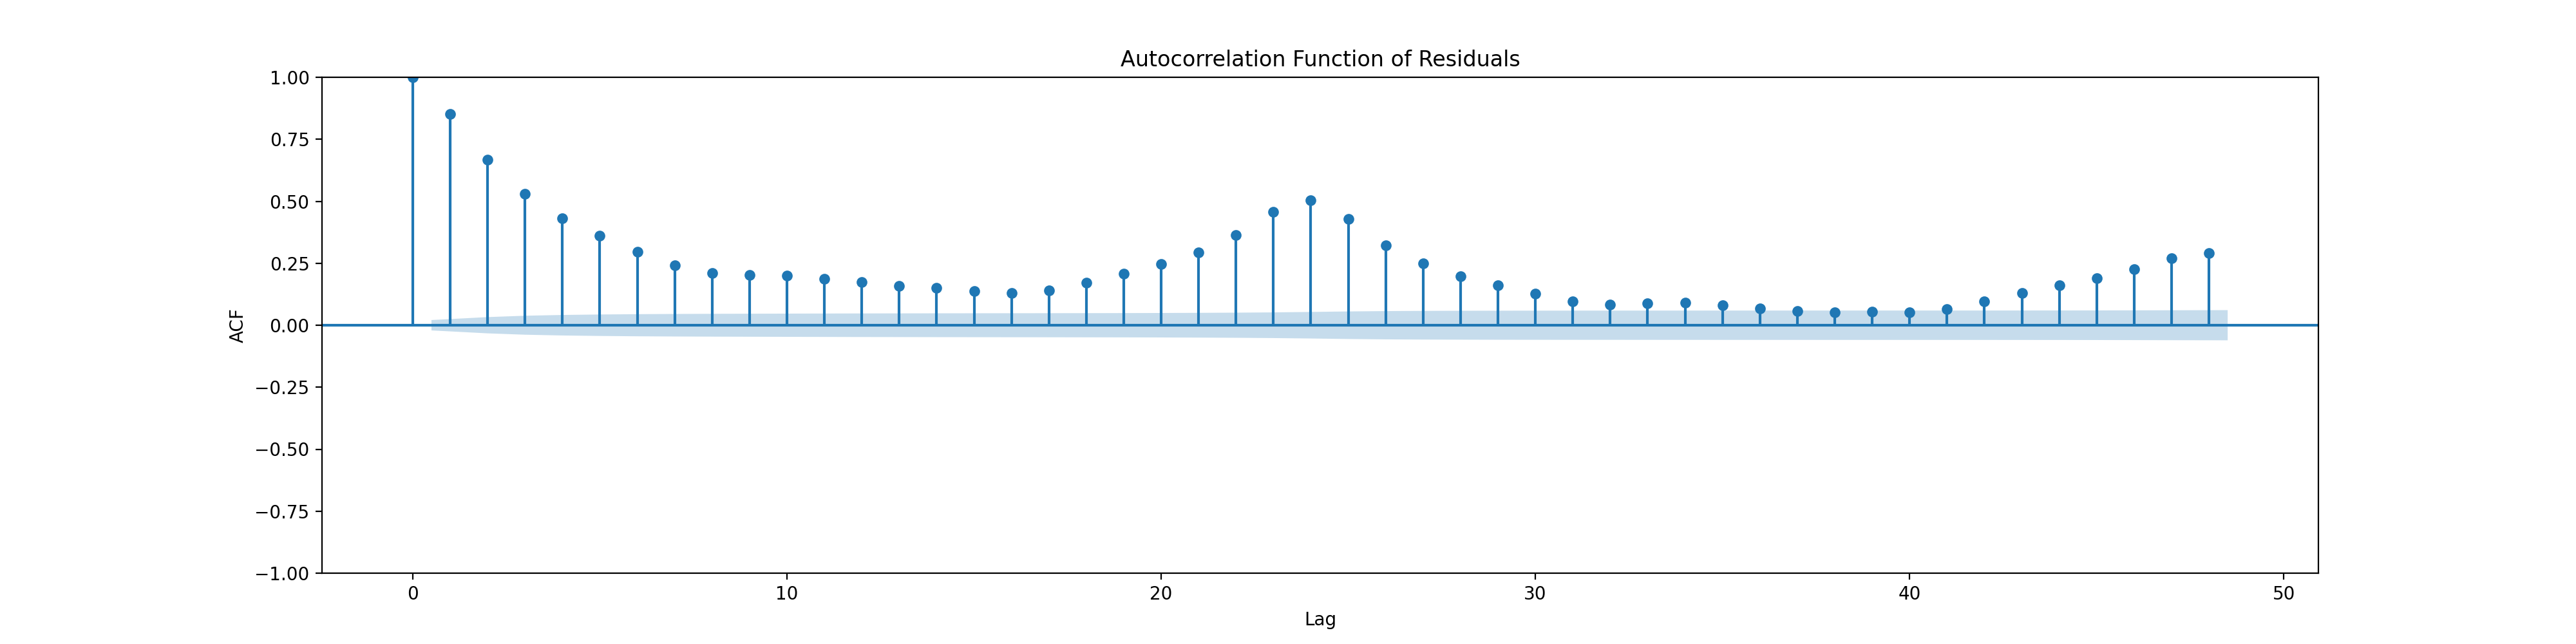

In [ ]:
# Fit the model and obtain predictions
y_pred = reg.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot ACF of residuals
fig, ax = plt.subplots(figsize=(20,5))
sm.graphics.tsa.plot_acf(residuals, lags=48, ax=ax)
ax.set(title='Autocorrelation Function of Residuals', xlabel='Lag', ylabel='ACF')
plt.show()

In [ ]:
# Calculate R^2 score
r2_test = r2_score(y_test, y_pred)
print("Out-of-Sample R^2 Score:", r2_test)

Out-of-Sample R^2 Score: 0.9253504723236593


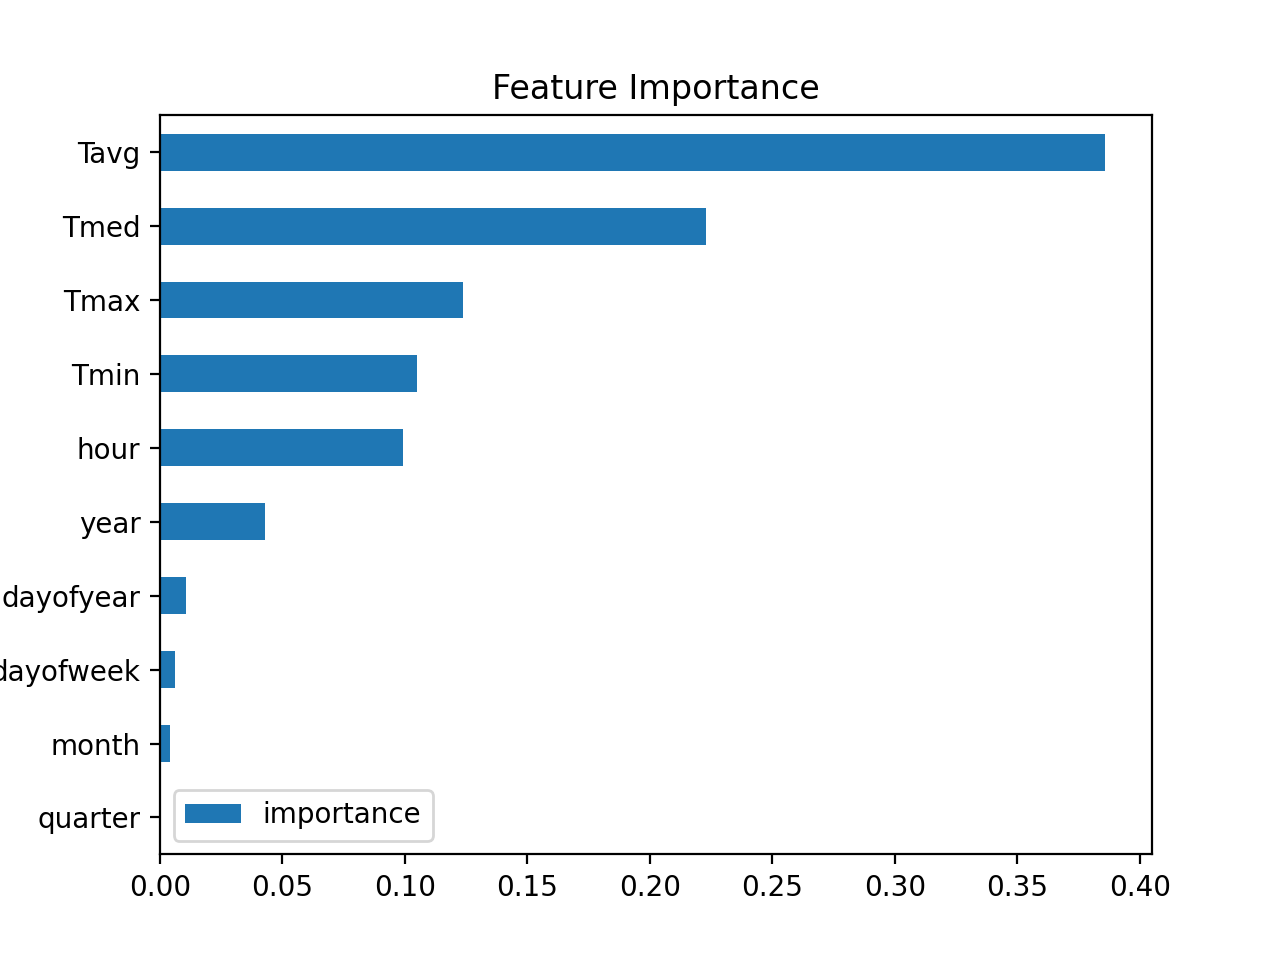

In [ ]:
#create a dataframe that shows the importance of the features in the model
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Gradient Boosted Tree Model Forecast

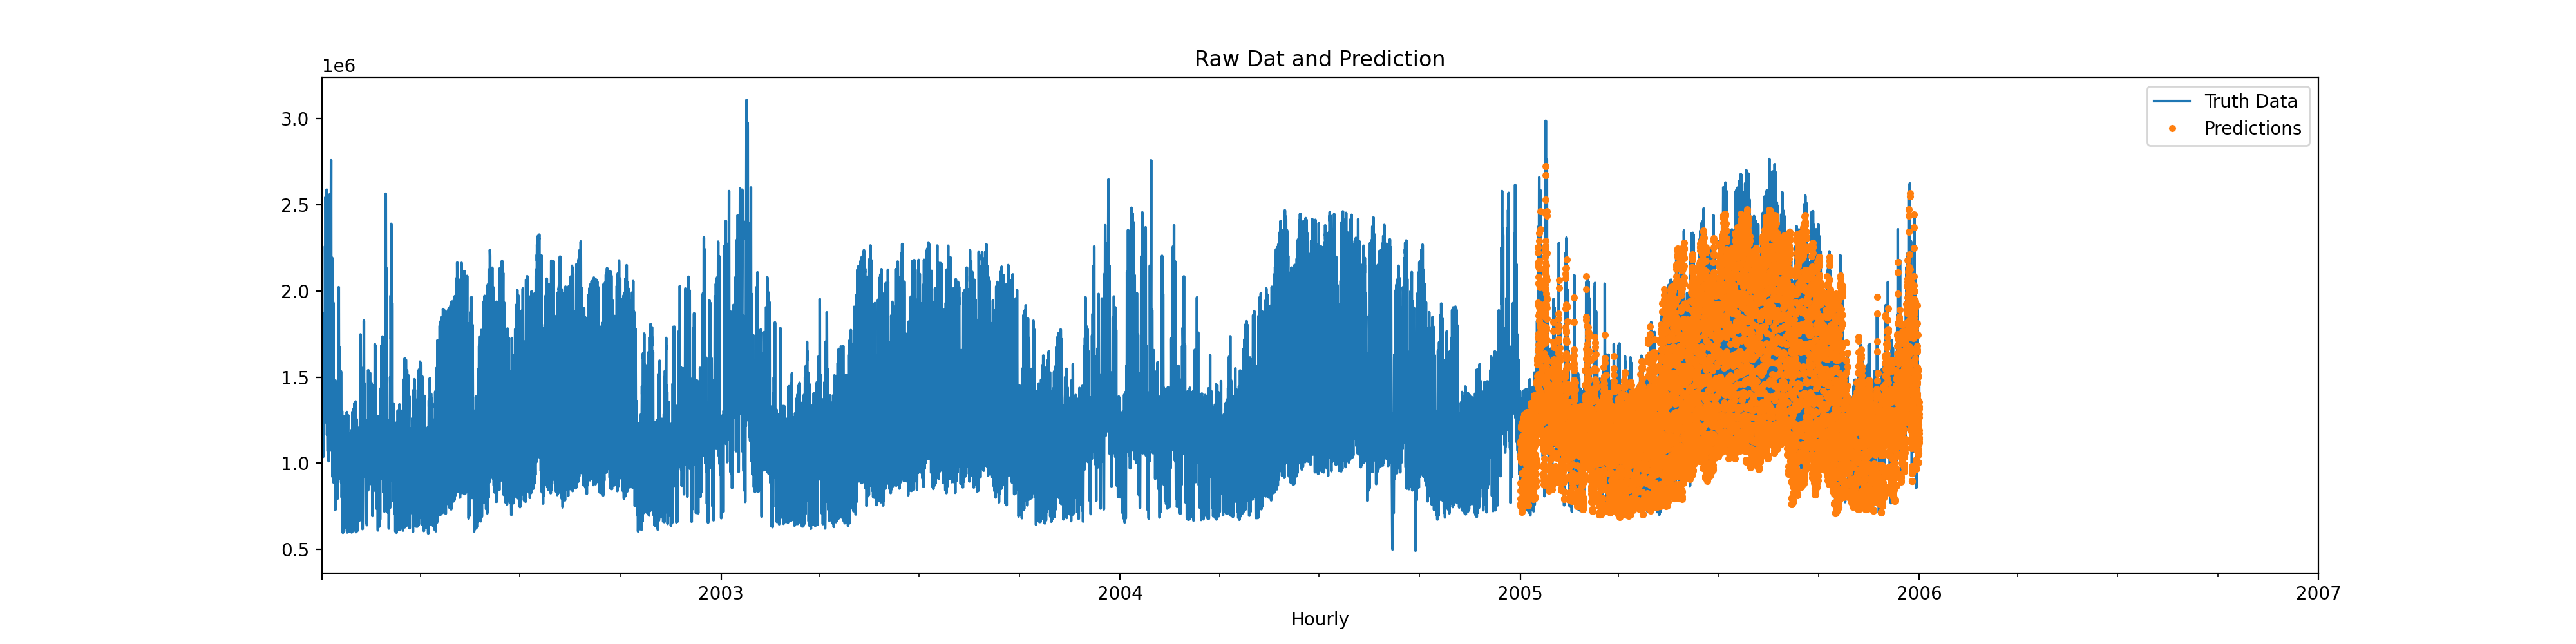

In [ ]:
#Forecast onto the test set
#creating new column to house the data
test['prediction'] = reg.predict(X_test)
#combining the info from training with the predicitons we will make based on index
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
#plotting predictions over the dataset
ax = df[['Load']].plot(figsize=(20, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# Gradient Boosted Tree Model Evaluation

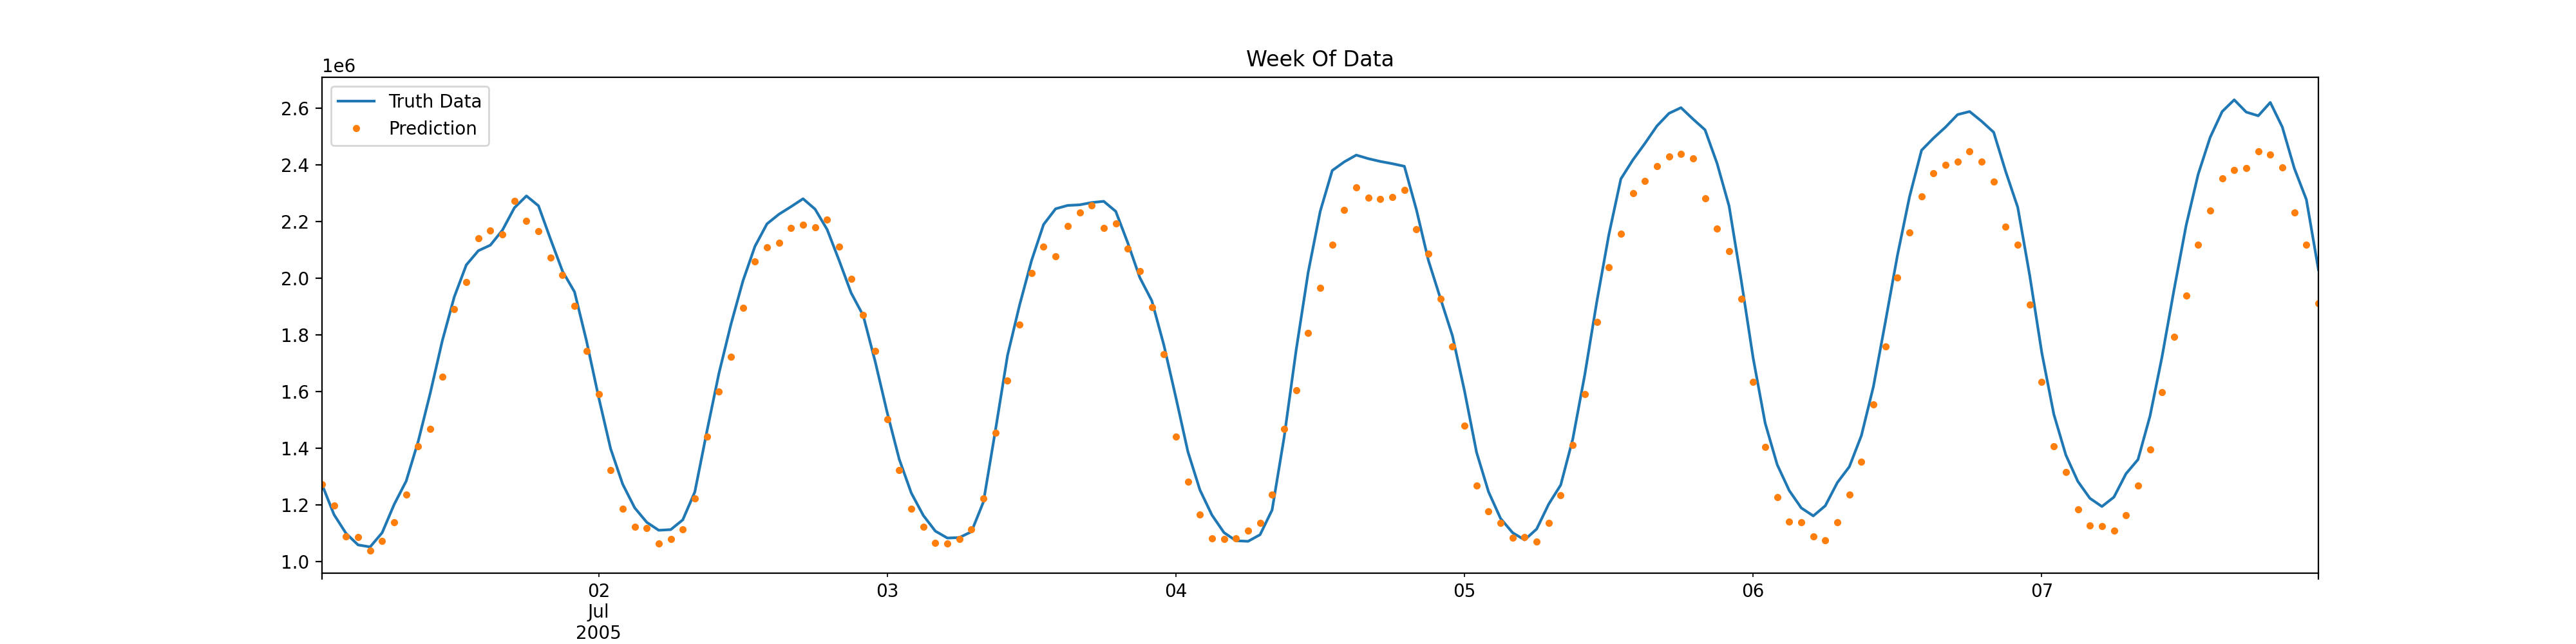

In [ ]:
#Plot a single week of predictions
ax = df.loc[(df.index > '2005-07-01') & (df.index < '2005-07-08')]['Load'] \
    .plot(figsize=(20, 5), title='Week Of Data')
df.loc[(df.index > '2005-07-01') & (df.index < '2005-07-08')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
#XGboost MAPE
XGBMAPE = 100*mean_absolute_percentage_error(test['Load'],test['prediction'])
print("MAPE: {:.2f}%".format(XGBMAPE))

MAPE: 6.38%


In [ ]:
#Find the days that were the worst predicted
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)
#couldnt finish implementation

date
2005-09-06    315135.679688
2005-09-07    308033.664062
2005-09-08    287535.625000
2005-09-27    271389.536458
2005-03-03    263008.421875
2005-12-17    246661.078125
2005-09-28    232594.385417
2005-03-09    223454.289062
2005-01-18    215546.911458
2005-12-07    210117.466146
Name: error, dtype: float64

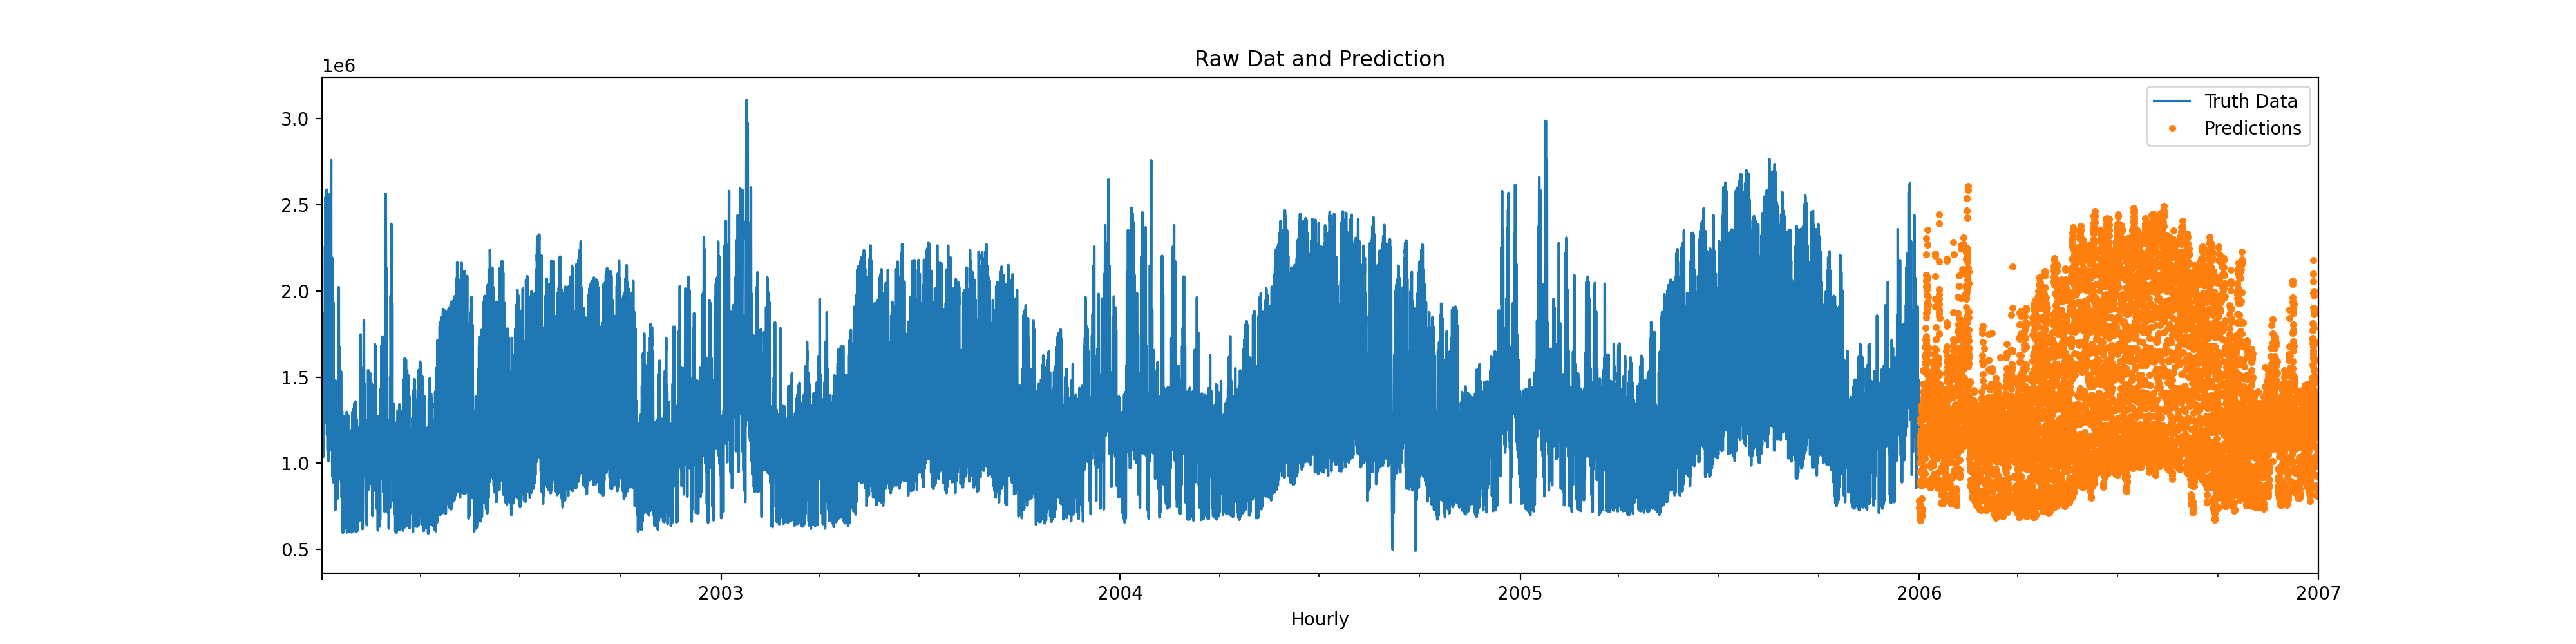

In [ ]:
#Forecast onto the 2006 data set
#creating new column to house the data
future['prediction2006'] = reg.predict(X_future)
#combining the info from training with the predicitons we will make based on index
df = df.merge(future[['prediction2006']], how='left', left_index=True, right_index=True)
#plotting predictions over the dataset
ax = df[['Load']].plot(figsize=(20, 5))
df['prediction2006'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# Assignment Goal Completion

In [ ]:
#Goal 1: 2006 hourly predictions
df_2006 = df.iloc[35064:,:]

#adding regression predicitons to dataset
pred1 = m3.get_prediction(df_2006)
pred2 = m2.get_prediction(df_2006)
pred3 = m1.get_prediction(df_2006)

pred1_mean = pred1.predicted_mean
pred2_mean = pred2.predicted_mean
pred3_mean = pred3.predicted_mean

df_2006['fitted_m3'] = pred1_mean[:]
df_2006['fitted_m2'] = pred2_mean[:]
df_2006['fitted_m1'] = pred3_mean[:]

df_2006.head()

<ipython-input-53-db7ac29f3e4c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-53-db7ac29f3e4c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-53-db7ac29f3e4c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Tavg  Tmed  Tmax  Tmin  Load  hour  dayofweek  quarter  \
Hourly                                                                        
2006-01-01 01:00:00    60  60.0  68.0  55.0   NaN     1          6        1   
2006-01-01 02:00:00    60  60.0  68.0  54.0   NaN     2          6        1   
2006-01-01 03:00:00    60  60.0  67.0  54.0   NaN     3          6        1   
2006-01-01 04:00:00    59  60.0  68.0  52.0   NaN     4          6        1   
2006-01-01 05:00:00    59  61.0  68.0  51.0   NaN     5          6        1   

                     month  year  dayofyear  dayofmonth  weekofyear  \
Hourly                                                                
2006-01-01 01:00:00      1  2006          1           1          52   
2006-01-01 02:00:00      1  2006          1           1          52   
2006-01-01 03:00:00      1  2006          1           1          52   
2006-01-01 04:00:00      1  2006          1           1          52   
2006-01-01 05:00:00      1  2006          1           1          52   

                     prediction  prediction2006     fitted_m3     fitted_m2  \
Hourly                                                                        
2006-01-01 01:00:00         NaN     780060.3750  9.782913e+05  1.011031e+06   
2006-01-01 02:00:00         NaN     741840.8750  1.007522e+06  1.054137e+06   
2006-01-01 03:00:00         NaN     694039.2500  9.987999e+05  1.042888e+06   
2006-01-01 04:00:00         NaN     702646.1875  8.988226e+05  1.015784e+06   
2006-01-01 05:00:00         NaN     704263.3125  7.902273e+05  9.851387e+05   

                        fitted_m1  
Hourly                             
2006-01-01 01:00:00  1.192340e+06  
2006-01-01 02:00:00  1.191898e+06  
2006-01-01 03:00:00  1.160237e+06  
2006-01-01 04:00:00  1.199699e+06  
2006-01-01 05:00:00  1.192603e+06

In [ ]:
#Goal 2: Peak daily loads
# group by day and apply max to xgb results
daily_max = df_2006.groupby(pd.Grouper(freq='D')).max()['prediction2006']
#can also use this for the naive models as well
#daily_max.m1 = df_2006.groupby(pd.Grouper(freq='D')).max()['fitted_m1']
#daily_max.m2 = df_2006.groupby(pd.Grouper(freq='D')).max()['fitted_m2']
#daily_max.m3 = df_2006.groupby(pd.Grouper(freq='D')).max()['fitted_m3']

#now we can put it into its own column in a new data frame to make it easier to read
df_goal2 = pd.DataFrame()
df_goal2['Max Load'] = daily_max
df_goal2.head()

Max Load
Hourly                 
2006-01-01  1259008.000
2006-01-02  1333494.125
2006-01-03  1305162.500
2006-01-04  1539482.250
2006-01-05  1450141.375

In [ ]:
#Goal 3: Hour of Max Load
#use idxmax instead of max since it will give us the datetime index of the max value for the day, from that we can extract the hour which will be our predicted peak hour
daily_maxhour_idx = df_2006.groupby(pd.Grouper(freq='D'))['prediction2006'].idxmax()

# extract the hour of the maximum value for each day
hour_of_max = daily_maxhour_idx.apply(lambda x: x.hour)

df_goal3 = pd.DataFrame()
df_goal3['Peak Hour'] = hour_of_max
df_goal3.head()

Peak Hour
Hourly               
2006-01-01         21
2006-01-02         20
2006-01-03         21
2006-01-04          8
2006-01-05          8

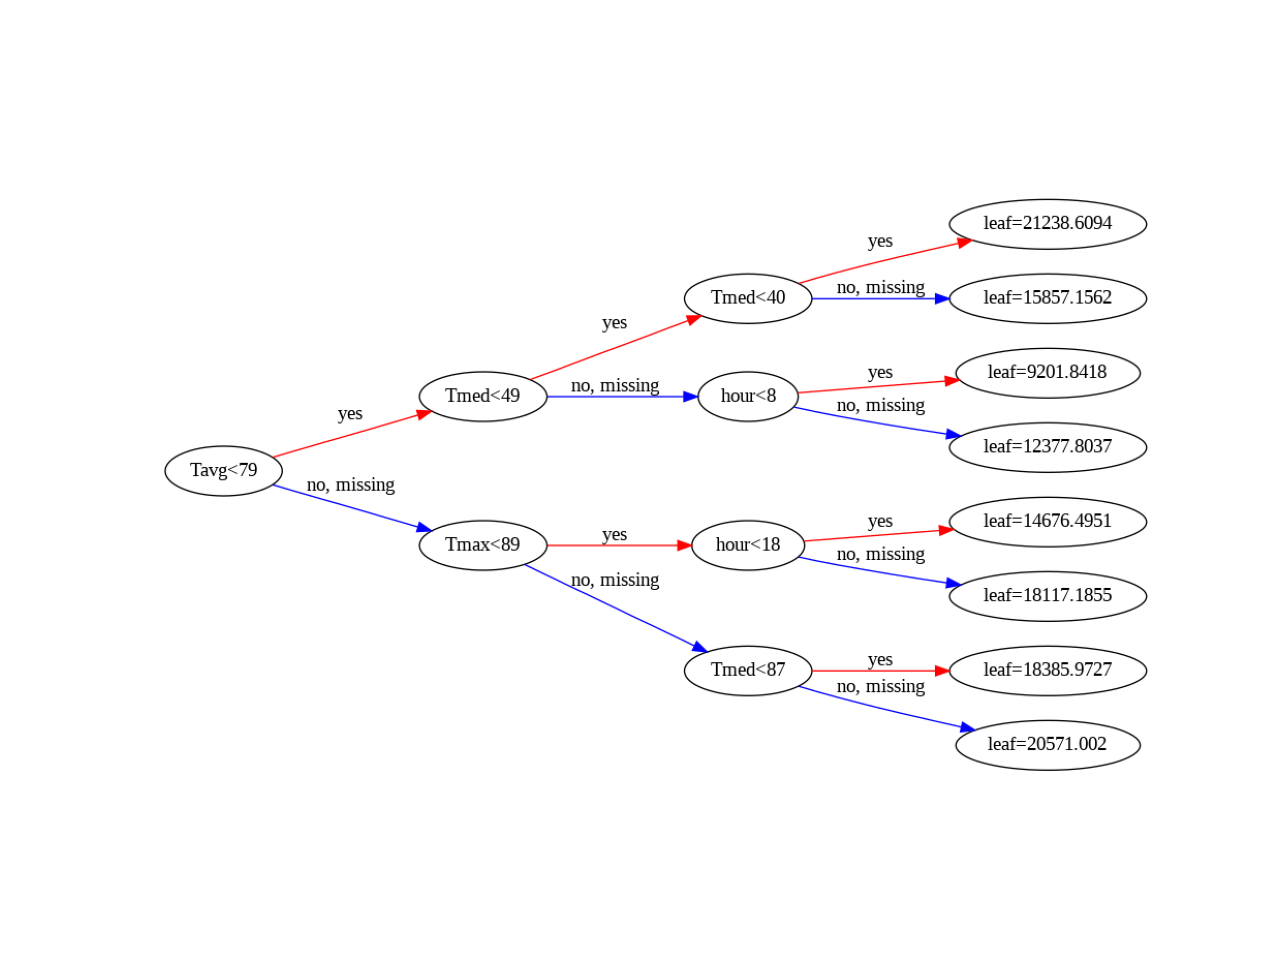

In [ ]:
plot_tree(reg, num_trees=1, rankdir='LR')  # Adjust num_trees to visualize different trees
plt.show()

In [ ]:
#Exporting the dataframes we need into excel for submission
#Goal 1 Final Predictions
#df_2006[['prediction2006']].to_excel('Goal1.xlsx', index=True)

In [ ]:
#Goal 2 Final Predictions
#df_goal2.to_excel('Goal2.xlsx', index=True)

In [ ]:
#Goal 3 Final Predictions
#df_goal3.to_excel('Goal3.xlsx', index=True)